<a href="https://colab.research.google.com/github/sanujsriv/_topic_models/blob/FoTo/FoTo_Feb21_Sentence_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %cd ./colab/FoTo_Sentence/
# %mkdir FoTo_Sent_Bernoulli
%cd ./colab/FoTo_Sentence/FoTo_Sent_Bernoulli/

# **Download Preprocessed Data (Sentences)**

In [ ]:
############################ BBC #########################################
# !wget https://www.dropbox.com/s/2m1gbuvk1lz151j/data_bbc.zip

## 64 batch size
# !wget https://www.dropbox.com/s/suivwmax9kmpu6r/n_s_v_dict_bbc_64.pkl
# !wget https://www.dropbox.com/s/kqpunihs8hgfzzm/all_indices_bbc_64.pkl
########################### BBC ##########################################


########################### 20News #######################################

###-----
# !wget https://www.dropbox.com/s/lnk001gexy74b0l/data.zip
# !wget https://www.dropbox.com/s/n2iy4ooviyteii4/doc_sentences.pkl

### 64 batch size
# !wget https://www.dropbox.com/s/3kb4zazcailqqy2/n_s_v_dict_64_id_14.pkl
# !wget https://www.dropbox.com/s/t5mxav9ytbzcci7/all_indices_id_14.pkl
###-----


## 32 batch size
# !wget https://www.dropbox.com/s/2gaodary4smyiml/all_indices_id_12.pkl
# !wget https://www.dropbox.com/s/y5mqy7mxzvimbde/n_s_v_dict_32_id_12.pkl

## 128 batch size
# !wget https://www.dropbox.com/s/jzyma764jyrs5we/n_s_v_dict_128_id_13.pkl
# !wget https://www.dropbox.com/s/8lja1ynyuvc0sff/all_indices_id_13.pkl
########################### 20News #######################################

#**unzip**

In [ ]:
import os

def unzip_bbc():
  os.system('unzip data_bbc.zip')

def unzip_20News():
  os.system('unzip data.zip')
  os.system('unzip train_vec_non_zeros.zip')


In [ ]:
unzip_bbc()
# unzip_20News()

#**# 0. Just Run these..**

In [ ]:
#@title Imports
# from sympy.stats import RaisedCosine, density
import torch
# import pandas as pd
from torch import nn
import re
# from matplotlib import pyplot as plt
import sys
import gc
import time
import numpy as np
import collections
import torch.optim as optim
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords
# import sklearn
# import re
# import string
# from numpy import random
# # from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize
# from nltk.corpus import stopwords
# from sklearn.datasets import fetch_20newsgroups
# from sklearn.datasets import fetch_rcv1
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#@title function : load / save pickle_obj
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return  pickle.load(f)

In [ ]:
#@title get_keywords
def get_keywords():
  keywords = []
  keywords_arxiv = ['molecular ','stimulation','liquid','fluid']

  keywords_webkb = ['class','student','department','year']
  # keywords_r52 = ['mutual','fund','market','money']

  keywords_WoS = ['pediatric','protein','clone']
  # keywords_20News_Reuters = ['oil','price','opec','bpd','barrel','saudi','production','mln','crude']

  keywords_reuters = ['company', 'analyst', 'offer', 'pct', 'takeover', 'merger', 'record', 'dividend', 'pay', 'stock']
  # keywords_reuters = ['stock', 'dividend', 'inc']

  # keywords_20News = ['baseball','game','sport','win']
  # keywords_20News = ['looking' ,'add', 'voice' ,'input', 'capability', 'user', 'interface']
  # keywords_20News = ['sport', 'baseball', 'game','match']

  keywords_20News = ['windows','mac','cpu','graphic' ,'disk']

  keywords_bbc = ['minister','security','politics','government']


  keywords = keywords_bbc

  return keywords

#**1. Model, Training, Testing, Visualization**

In [ ]:
# @title Data Loading functions..
def load_bbc_sentences():
  doc_preprocessed = load_obj('doc_preprocessed_nonzeroes')
  doc_preprocessed_labels = load_obj("doc_preprocessed_nonzeroes_labels")
  embeddings = load_obj('embeddings')
  doc_id_sent = load_obj('doc_id_sent_nonzeros')
  sen_preprocessed = load_obj('sen_preprocessed_nonzeroes')
  train_vec = load_obj('train_vec_non_zeros')
  vocab = load_obj('vocab')
  all_rscores = None
  return doc_preprocessed,doc_preprocessed_labels,embeddings,doc_id_sent,sen_preprocessed,train_vec,vocab,all_rscores,load_bbc_sentences.__name__


def load_20News_sentences():
  doc_preprocessed = load_obj('doc_preprocessed_nonzeroes')
  doc_preprocessed_labels = load_obj("doc_preprocessed_nonzeroes_labels")
  embeddings = load_obj('embeddings_20news')
  doc_id_sent = load_obj('doc_id_sent_nonzeros')
  sen_preprocessed = load_obj('sen_preprocessed_nonzeroes')
  train_vec = load_obj('train_vec_non_zeros')
  vocab = load_obj('vocab')
  all_rscores = load_obj('all_rscores')
  return doc_preprocessed,doc_preprocessed_labels,embeddings,doc_id_sent,sen_preprocessed,train_vec,vocab,all_rscores,load_20News_sentences.__name__

In [ ]:
# ##### Data loading #####
# loaded_data = load_20News_sentences
loaded_data = load_bbc_sentences

##########################

doc_preprocessed,doc_preprocessed_labels,embeddings,doc_id_sent,sen_preprocessed,train_vec,vocab,all_rscores, name = loaded_data()
print(name,len(doc_preprocessed_labels),len(doc_preprocessed),len(embeddings),len(doc_id_sent),len(sen_preprocessed))
print(len(doc_preprocessed),max(doc_id_sent)+1)

load_bbc_sentences 2225 2225 5000 33571 33571
2225 2225


In [ ]:
def most_frequent(List):
    return max(set(List), key = List.count)
most_freq = most_frequent(doc_id_sent)
max_sent = doc_id_sent.count(most_freq)
most_freq , max_sent

(1185, 186)

In [ ]:
# max_sentences = max_sent
max_sent = 186

In [ ]:
doc_sentences = load_obj('doc_sentences')

#**2. Model hyper-parameters**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_vec = np.array(train_vec) ## S x V
train_label = np.asarray(doc_preprocessed_labels)
id_vocab = dict(map(reversed, vocab.items()))
num_voc = len(id_vocab)

num_coordinate = 2
bs=32
# bs=20
en1_units_x = 100
en2_units_x = 100
num_input = train_vec[0].shape[0]
variance_x = 1
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.6
num_topic = 20
gc.collect()

0

In [ ]:
def get_mem_size(a):
  return 'Mem Size: '+str(a.element_size()*a.nelement() /(1024**3))+' GB'

#**3. Bernoulli v2 - Avg. Fraction of Sentences**

In [ ]:
def padarray(A, size,criteria):
    A = list(A)
    if criteria=='top':
      A[::-1].sort()
    elif criteria=='first':
      pass
    t = size - len(A)
    if t<=0:
      return A[:size]
    else:
      for _ in range(t):
        A.append(2)
      return A

In [ ]:
sen_kw = []
avg_frac = np.array([])

keys  = get_keywords()
for s in sen_preprocessed:
  key_indicator = 0
  for k in keys:
    # if k in s:
    if re.search(r'\b' + k + r'\b', s):
      key_indicator = 1
      sen_kw.append(key_indicator)
      break
  if key_indicator == 0:
    sen_kw.append(key_indicator)
sen_kw =np.array(sen_kw)
score = [sen_kw[i] for i in doc_sentences]

for i in range(len(score)):
  avg_frac=np.append(avg_frac,score[i].mean())
avg_frac=torch.tensor(avg_frac)

In [ ]:
###### Testing -

# sen_kw = []
# avg_frac = np.array([])

# keys  = get_keywords()
# key_indicator = 1
# for s in sen_preprocessed:

#   # for k in keys:
#   #   # if k in s:
#   #   if re.search(r'\b' + k + r'\b', s):
#   #     key_indicator = 1
#   #     sen_kw.append(key_indicator)
#   #     break
#   # if key_indicator == 0:
#   sen_kw.append(key_indicator)
# sen_kw =np.array(sen_kw)
# score = [sen_kw[i] for i in doc_sentences]

# for i in range(len(score)):
#   avg_frac=np.append(avg_frac,score[i].mean())
# avg_frac=torch.tensor(avg_frac)

In [ ]:
for i in range(len(score)):
  score[i] = padarray(score[i],max_sent,'first')
key_indicator = torch.tensor(np.array(score))
key_indicator = key_indicator.unsqueeze(2).expand(avg_frac.shape[0],max_sent,1)
key_indicator_pseudo = torch.where(key_indicator > 1, 0, 1)
avg_fracs=avg_frac.unsqueeze(1).unsqueeze(1).expand(avg_frac.shape[0],max_sent,1)
key_indicator_revert = torch.where(key_indicator < 2, key_indicator, 0)

In [ ]:
key_indicator_revert.shape

torch.Size([2225, 186, 1])

In [ ]:
avg_test = torch.ones(2225,max_sent,1) * 0.0000001

In [ ]:
# Testing
# t = k = 1221
# doc_sentences[k],sen_preprocessed[min(doc_sentences[k]):max(doc_sentences[k])+1],doc_preprocessed[k]
# key_indicator_pseudo[t].squeeze().sum(-1),len(doc_sentences[t])
# torch.sort(avg_frac,descending=True)

# **4. all_indices, sparse_matrix, cached_input** *(Just Run Once)*

In [ ]:
#@title sparse matrix : temp code

# num_doc = max(doc_id_sent)+1
# s_v_num_nonzeros = np.count_nonzero(train_vec)
# s_v_i = torch.zeros((3, s_v_num_nonzeros),dtype=torch.long)
# s_v_float = torch.zeros(s_v_num_nonzeros)
# count = 0

# for i,j in enumerate(doc_sentences):
#   # print(i,count)
#   s_v_i[0][count] = i
#   for k,l in enumerate(j):
#     s_v_i[1][count] = k
#     for m,n in enumerate(train_vec[l]):
#       if(n!=0):
#         s_v_i[2][count] = m
#         s_v_float[count]= torch.tensor(n)
#         count = count + 1

In [ ]:
all_indices = torch.randperm(len(doc_preprocessed)).split(bs)
# all_indices = load_obj('all_indices_bbc_64')
# n_s_v_dict = load_obj('n_s_v_dict_bbc_64')

In [ ]:
bs,max_sent

(32, 186)

In [ ]:
##@title Sparse matrix : if all_indices change run this..

# from collections import OrderedDict
# n_s_v_dict = OrderedDict()

# # Sparse Matrix for Batch Size : 64

# bs = 32
sent = max_sent
n_s_v_dict = {}

for d,batch_ndx in enumerate(all_indices):
  count = 0
  s_v_num_nonzeros = 0

  for j,i in enumerate(batch_ndx):
    if (len(doc_sentences[i.item()])>sent):
      s_v = train_vec[doc_sentences[i.item()][0:sent]]
    else:
      s_v = train_vec[doc_sentences[i.item()]]
    s_v_num_nonzeros = s_v_num_nonzeros + np.count_nonzero(s_v)
  s_v_i = torch.zeros((3, s_v_num_nonzeros),dtype=torch.long)
  s_v_float = torch.zeros(s_v_num_nonzeros)

  for j,i in enumerate(batch_ndx):
    ss = doc_sentences[i.item()]
    for k,l in enumerate(ss):
      if k>=sent: break
      nz = np.nonzero(train_vec[l])
      for m in nz[0]:
        s_v_i[0][count] = j
        s_v_i[1][count] = k
        s_v_i[2][count] = m
        s_v_float[count] = torch.tensor(train_vec[l][m])
        #if(torch.tensor(train_vec[l][m])== torch.tensor(0.0)): print('*********************')
        count = count + 1
  n_s_v_dict[d] = torch.sparse.FloatTensor(s_v_i, s_v_float, torch.Size([batch_ndx.shape[0],max_sent,num_voc]))
gc.collect()

0

In [ ]:
#@title Check if nsv == train_vec tensor
# b_batches = len(all_indices) # bbc : 35 batches (0-34) , how many batches we have
# s_sentences = sent # sentence (0-49)

# check_all_true = []

# for b in range(b_batches):
#   d_documents = n_s_v_dict[b].to_dense().shape[0]
#   for d in range(d_documents):
#     for s in range(s_sentences):
#       nsv_val = n_s_v_dict[b].to_dense()[d][s].sum()
#       if s >= len(doc_sentences[all_indices[b][d].item()]):
#         val = 0.0
#       else :
#         val = train_vec[doc_sentences[all_indices[b][d].item()][s]].sum()
#       check_all_true.append(nsv_val.item() == val)
# all(check_all_true) # true if all are true

In [ ]:
# ##@title Document & Word with max word count
# def max_word_count(l):
#   return max(dict((x,l.count(x)) for x in set(l)).items(), key=lambda k: k[1])

# values=[]
# values_idx = []
# max_idx_batch = []
# max_batch_val = []

# for i in range(35):
#   a = n_s_v_dict[i].to_dense()
#   values.append(a.max())
#   values_idx.append(torch.where(a == a.max()))

# for i,j in enumerate(values):
#   if j==max(values):
#     max_idx_batch.append(i)
#     max_batch_val.append(j)

# for m_idx in range(len(max_idx_batch)):
#   max_word_idx = values_idx[max_idx_batch[m_idx]]
#   doc_max_word_id = all_indices[max_idx_batch[m_idx]][max_word_idx[0].item()].item()
#   print('batch - ',max_idx_batch[m_idx],'| max-batch-value - ',max_batch_val[m_idx].item(),'| max_word_idx - ',max_word_idx)
#   print('document id with max word count is : ',doc_max_word_id)
#   print('max word-count : ',max_word_count(doc_preprocessed[doc_max_word_id].split(' ')))

In [ ]:
np.where(train_vec ==  train_vec.max()), train_vec.max()

((array([11003, 22516]), array([1776, 3861])), 20.0)

In [ ]:
# ar_sen_prep = np.array(sen_preprocessed)
# all_words_in_sentences = []
# char_splits = np.char.split(ar_sen_prep[doc_sentences[doc_max_word_id]])
# for c in char_splits:
#   all_words_in_sentences.extend(c)
# print('max-word-count : ',max_word_count(all_words_in_sentences))

In [ ]:
# torch.where(n_s_v_dict[max_idx_batch].to_dense() ==n_s_v_dict[max_idx_batch].to_dense().max())

In [ ]:
#@title (hardcoded) check where word count > 1
# b,d,s = 34, 24, 3
# max(n_s_v_dict[b].to_dense()[d][s]),max(train_vec[doc_sentences[all_indices[b][d].item()][s]]),np.where(train_vec[doc_sentences[all_indices[b][d].item()][s]]>1)

In [ ]:
# save_obj(n_s_v_dict,'n_s_v_dict_bbc_64')
# save_obj(all_indices,'all_indices_bbc_64')

In [ ]:
# del cached_nsv
# del cached_inputw
gc.collect()

176

In [ ]:
# del cached_nsv,cached_inputw
cached_inputw = []
# cached_nsv= []

gc.collect()
for d,batch_ndx in enumerate(all_indices):
  # if(d<=300):
  #   cached_nsv.append(n_s_v_dict[d].to_dense())
  cached_inputw.append(n_s_v_dict[d].to_dense().sum(dim=1))
gc.collect()

0

# **Current Model**


In [ ]:
#@title Weight Drop
def _weight_drop(module, weights, dropout):
    """
    Helper for `WeightDrop`.
    """
    for name_w in weights:
        w = getattr(module, name_w)
        del module._parameters[name_w]
        module.register_parameter(name_w + '_raw', Parameter(w))

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_w in weights:
            raw_w = getattr(module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=dropout, training=module.training)

            setattr(module, name_w, w)

        # return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)


class WeightDrop(torch.nn.Module):
    """
    The weight-dropped module applies recurrent regularization through a DropConnect mask on the
    hidden-to-hidden recurrent weights.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        module (:class:`torch.nn.Module`): Containing module.
        weights (:class:`list` of :class:`str`): Names of the module weight parameters to apply a
          dropout too.
        dropout (float): The probability a weight will be dropped.

    Example:

        >>> from torchnlp.nn import WeightDrop
        >>> import torch
        >>>
        >>> torch.manual_seed(123)
        <torch._C.Generator object ...
        >>>
        >>> gru = torch.nn.GRUCell(2, 2)
        >>> weights = ['weight_hh']
        >>> weight_drop_gru = WeightDrop(gru, weights, dropout=0.9)
        >>>
        >>> input_ = torch.randn(3, 2)
        >>> hidden_state = torch.randn(3, 2)
        >>> weight_drop_gru(input_, hidden_state)
        tensor(... grad_fn=<AddBackward0>)
    """

    def __init__(self, module, weights, dropout=0.0):
        super(WeightDrop, self).__init__()
        _weight_drop(module, weights, dropout)
        self.forward = module.forward

class WeightDropLinear(torch.nn.Linear):
    """
    Wrapper around :class:`torch.nn.Linear` that adds ``weight_dropout`` named argument.

    Args:
        weight_dropout (float): The probability a weight will be dropped.
    """

    def __init__(self, *args, weight_dropout=0.0, **kwargs):
        super().__init__(*args, **kwargs)

        weights = ['weight']
        # print('name_w in _weight_drop: ', name_w)
        _weight_drop(self, weights, weight_dropout)


In [ ]:
# @title Targeted Dropout Class
import torch
import torch.nn as nn


class TargetedDropout(nn.Module):
    """
    Learning Sparse Networks Using Targeted Dropout
    https://arxiv.org/abs/1905.13678
    """

    def __init__(self,targeted="weight",target_layer=None,
                 dropout_rate=0.5,targeted_portion=0.5):
        super(TargetedDropout, self).__init__()
        self.targeted = targeted
        self.target_layer = target_layer
        self.dropout_rate = dropout_rate
        self.targeted_portion = targeted_portion
        self.weight = target_layer.weight

        if self.targeted == "weight":
            self.targeted_dropout = targeted_weight_dropout
        elif self.targeted == "unit":
            self.targeted_dropout = targeted_unit_dropout

    def forward(self):
        self.weight = self.targeted_dropout(
            weight=self.target_layer.weight,
            dropout_rate=self.dropout_rate,
            targeted_portion=self.targeted_portion,
            is_training=self.training,
        )

        self.target_layer.weight = self.weight
        # output = self.target_layer(x)
        return self.weight

    def extra_repr(self):
        return f"targeted={self.targeted}, dropout_rate={self.dropout_rate}, targeted_portion={self.targeted_portion}"


def targeted_weight_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.abs(weight)
    idx = int(targeted_portion * torch.tensor(weight.shape[0]).float())
    threshold = torch.sort(norm, dim=0)[0][idx]
    mask = norm < threshold[None, :]

    if not is_training:
        mask = (torch.rand_like(weight) < dropout_rate).to(mask.device.type) & mask

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

def targeted_unit_dropout(weight, dropout_rate, targeted_portion, is_training):
    weight_shape = weight.shape
    weight = torch.reshape(weight, [-1, weight_shape[-1]]).float()

    norm = torch.norm(weight, dim=0)
    idx = int(targeted_portion * int(weight.shape[1]))
    sorted_norms = torch.sort(norm)[0]
    threshold = sorted_norms[idx]
    mask = (norm < threshold)[None, :]
    mask = mask.repeat(weight.shape[0], 1)

    if not is_training:
        mask = torch.where(
            ((1.0 - dropout_rate) < torch.rand_like(weight)).to(mask.device.type)
            & mask,
            torch.ones_like(weight, dtype=torch.float32),
            torch.zeros_like(weight, dtype=torch.float32),
        )

    weight = (1.0 - mask.float()) * weight
    weight = torch.reshape(weight, weight_shape)
    weight = torch.nn.Parameter(weight)

    return weight

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
torch.cuda.empty_cache()

pi = 3.1415927410125732

#phi
def gaussian(alpha): return -0.5*alpha
def inverse_multi_quadric(alpha): return -0.5*torch.log(torch.ones_like(alpha) + alpha)
def inverse_quadratic(alpha): return -torch.log(torch.ones_like(alpha) + alpha)

class FoTo(nn.Module):
    def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, distance="gaussian"):
        super(FoTo, self).__init__()
        self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs,\
            = num_input, num_coordinate, num_topic, variance_x, bs

        self.TV_size = (num_topic,num_input)

        # encoder

        # self.en1_fc     = nn.Linear(num_input*max_sent, en1_units_x)          # inp_layer(5000) -> 100 # nx s*v->(s*vxh1)->nxh1;

        self.en1_fc     = nn.Linear(num_input, en1_units_x)
        self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)           # 100  -> 100
        self.en2_drop   = nn.Dropout(drop_rate)
        self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.mean_bn    = nn.BatchNorm1d(num_coordinate)                # bn for mean
        self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
        self.logvar_bn  = nn.BatchNorm1d(num_coordinate)                # bn for logvar

        # RBF
        self.in_features = self.num_coordinate
        self.out_features = self.num_topic
        self.centres = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        # self.query_center = nn.Parameter(torch.zeros(2,1))


        if distance=="gaussian": self.basis_func = gaussian
        if distance=="inverse_quadratic": self.basis_func = inverse_quadratic
        if distance=="inverse_multi_quadric": self.basis_func = inverse_multi_quadric
        self.init_parameters()

        # decoder

        self.decoder  = nn.Linear(self.num_topic, self.num_input) #T X V
        # self.weighDrop = WeightDropLinear(self.num_topic, self.num_input, weight_dropout=0.5) # T x V
        # self.targetedDrop = TargetedDropout(targeted="weight",target_layer=nn.Linear(self.num_topic, self.num_input)
        # ,dropout_rate=0.9, targeted_portion=0.9) # T x V

        self.decoder_bn = nn.BatchNorm1d(self.num_topic)                    # bn for decoder
        self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)                # bn for phi decoder
        self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)                  # bn for x decoder

        # prior mean and variance as constant buffers
        prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
        prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)

        self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
        self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
        self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)

    def init_parameters(self): nn.init.normal_(self.centres, 0, 0.01)

    def encode(self, input_):

        N = input_.size()[0]
        en1 = F.softplus(self.en1_fc(input_))                           # en1_fc   output
        en2 = F.softplus(self.en2_fc(en1))                              # encoder2 output
        en2 = self.en2_drop(en2)

        posterior_mean   = self.mean_bn(self.mean_fc(en2))              # posterior mean
        posterior_logvar = self.logvar_bn(self.logvar_fc(en2))          # posterior log variance
        posterior_var    = posterior_logvar.exp()

        return en2, posterior_mean, posterior_logvar, posterior_var

    def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
        # reparameterization
        eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1)
        z = posterior_mean + posterior_var.sqrt() * eps
        return z

    def decode(self, z):
        # decode
        N = z.size()[0]
        size = (N, self.out_features, self.in_features) # NxTx2
        zx = self.decoder_x_bn(z).unsqueeze(1) # Nx1x2
        x = zx.expand(size)
        c = self.decoder_phi_bn(self.centres).unsqueeze(0).expand(size)
        d = (x-c).pow(2).sum(-1)
        distances = self.basis_func(d) #NxT
        zx_phi = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True))

        ######################################################################################################################

        NS_size = (N,max_sent)

        ### P(W|z) ||  N x S x T x V ###

        W = F.softmax(self.decoder_bn(self.decoder.weight).transpose(1,0),dim=-1).unsqueeze(0).unsqueeze(0).expand(NS_size+self.TV_size)

        ## Weight Dropout
        # self.weighDrop.forward()
        # W = F.softmax(self.decoder_bn(self.weighDrop.weight).transpose(1,0),dim=-1).unsqueeze(0).unsqueeze(0).expand(NS_size+self.TV_size)

        ## Targeted Dropout
        # W = F.softmax(self.decoder_bn(self.targetedDrop.forward()).transpose(1,0),dim=-1).unsqueeze(0).unsqueeze(0).expand(NS_size+self.TV_size)

        ### P(z|x) ||  N x S x T ### (Theta)
        #Z = zx_phi.unsqueeze(1).unsqueeze(-1).expand(N,max_sent,self.num_topic,2) # N x S x T x 2
        Z = zx_phi.unsqueeze(1).expand(N,max_sent,self.num_topic)

        ### P(r|x,phi) || N x S ### (relv_status = {0,1})
        # theta_1= torch.narrow(Z,2,0,1) # theta_1 for N x S

        pr_0 = torch.zeros(N,max_sent,self.num_topic) #r=0, NxSxT
        pr_0[:,:,0] = 1 ### First Topic is irrelv

        # pr_0[:,:,self.num_topic//2] = 1 #middle topic (Topic 10)

        pr_1 = 1 - pr_0 #r=1
        pr = torch.cat((pr_0.unsqueeze(-1),pr_1.unsqueeze(-1)),-1).to(device) # N x S x T x 2

        ##########################################################################################################################

        # recon_v = torch.mm(zx_phi, F.softmax(self.decoder_bn(self.decoder.weight).transpose(1,0), dim=-1))
        return zx,zx_phi, d, c, W, Z,pr,pr_0,pr_1

    def forward(self, input_,kI,kI_p, avg_frac, gpu_n_s_v, compute_loss=False):
        fstart = time.time()
        # gpu_n_s_v_flatten = torch.flatten(gpu_n_s_v,start_dim=1)
        # en2, posterior_mean, posterior_logvar, posterior_var = self.encode(gpu_n_s_v_flatten) # nx s*v
        en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)

        z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

        # decode
        zx,zx_phi,d,c, W, Z,pr,pr_0,pr_1= self.decode(z)

        if compute_loss:
          lossN, NegativeLogL_RScore_mean, return_xKLD_mean \
          = self.loss(gpu_n_s_v,posterior_mean, posterior_logvar, posterior_var, W, Z,pr,pr_0,pr_1, kI,kI_p,avg_frac)
          return lossN, NegativeLogL_RScore_mean, return_xKLD_mean,time.time()-fstart
        else:
          return z, zx, zx_phi

    def KLD(self, posterior_mean,posterior_logvar,posterior_var):
        N = posterior_mean.shape[0]
        prior_mean   = self.prior_mean.expand_as(posterior_mean)
        prior_var    = self.prior_var.expand_as(posterior_mean)
        prior_logvar = self.prior_logvar.expand_as(posterior_mean)

        var_division    = posterior_var  / prior_var
        diff            = posterior_mean - prior_mean
        diff_term       = diff * diff / prior_var
        logvar_division = prior_logvar - posterior_logvar

        xKLD = 0.5 * ((var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
        xKLD_mean = xKLD.mean()
        return xKLD_mean

    def loss(self,gpu_n_s_v,posterior_mean, posterior_logvar,posterior_var, W, Z,pr,pr_0,pr_1, kI,kI_p,avg_frac, avg=True):
        N = posterior_mean.shape[0]
        xKLD_mean = self.KLD(posterior_mean,posterior_logvar,posterior_var)

        input_nstv = gpu_n_s_v.unsqueeze(2).expand((gpu_n_s_v.shape[0],max_sent)+self.TV_size)
        smoothen = 1e-12

        ns_1 = torch.ones(N,max_sent,1).to(device)
        ns_0 = 1.0-ns_1

        pkw_r1 = torch.cat((1-avg_frac,avg_frac),2).unsqueeze(2).expand(N,max_sent,self.num_topic,2) #NxSxTx2 (for (kw=0 | kw=1)  r=1 only)
        pkw_r0 = torch.cat((ns_1,ns_0),2).unsqueeze(2).expand(N,max_sent,self.num_topic,2) #NxSxTx2 (for (kw=0 | kw=1) r=0 only)
        pkw =  torch.cat((pkw_r0.unsqueeze(-1),pkw_r1.unsqueeze(-1)),-1)
        kI_NST22 = kI.unsqueeze(-1).unsqueeze(-1).expand(N,max_sent,self.num_topic,2,2)
        #kI_p_NST = kI_p.expand(N,max_sent,self.num_topic)
        kI_p = kI_p.squeeze(-1)

##########################################################################
        W_I = (W**input_nstv).prod(-1) # N X S X T
        # print(input_nstv[0].sum(-1))
        #R_Z =  (pr * ( (pkw[:,:,:,0,:]**(1-kI_NST22[:,:,:,0,:]))*(pkw[:,:,:,1,:]**(kI_NST22[:,:,:,1,:]))).squeeze(-2) * Z).sum(-1)
        R_Z = Z
        NegativeLogL_RScore_mean = - ((((W_I * R_Z).sum(-1))**kI_p + smoothen).log()).sum(-1).mean()
##########################################################################

        loss = xKLD_mean + NegativeLogL_RScore_mean
        # print(N)
        return loss, NegativeLogL_RScore_mean, xKLD_mean

        # p(kw = 1|rs = 0) = 0
        # p(kw = 1|rs = 1) == avg frac
        # p(kw = 0|rs = 0) == 1
        # p(kw = 0|rs = 1) == 1-avg frac

p(r|x,phi): **NxSxTx2**

p(z|x): NxT --> unsqueeze --> **NxSxT**

p(w|z): TxV --> unsqueeze x 2 --> **NxSxTxV**

input_w: NxSxV --> unsqueeze --> **NxSxTxV**

log(sum ( *NxSxT* (R_L).sum(-1) * NxSxT (Z) * product((NxSxTxV)^input_w, dim=-1) NxSxT, dim = -1) ).sum()

# **Train Model**

In [ ]:
model = FoTo(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, "inverse_quadratic")
# device = 'cpu'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
epochs = 50
x_arr,recon_arr = [],[]
for epoch in range(epochs):
    loss_u_epoch = 0.0
    loss_xkl_epoch = 0.0
    loss_epoch = 0.0
    model.train()

    for d,batch_ndx in enumerate(all_indices):
        gpu_n_s_v = n_s_v_dict[d].to(device).to_dense()
        input_w = cached_inputw[d].to(device)
        # avg_frac_b = avg_fracs[batch_ndx].to(device)
        avg_frac_b = avg_test[batch_ndx].to(device)
        kI = key_indicator_revert[batch_ndx].to(device)
        kI_p = key_indicator_pseudo[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        (loss, loss_u, xkl_loss,forward_time) = model(input_w, kI,kI_p, avg_frac_b, gpu_n_s_v, compute_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()             # backpror.step()            # update parameters
        loss_u_epoch += loss_u.item()
        loss_xkl_epoch += xkl_loss.item()

    x_arr.append(loss_xkl_epoch)
    recon_arr.append(loss_u_epoch)

    if epoch % 1 == 0:
        print('Epoch -> {}'.format(epoch))
        print('loss==> {} || KLD==> {}'.format(loss_u_epoch, loss_xkl_epoch))

# **Functions (Plot_loss, get_topwords, get_Z, get_Contour, print_Topics)** - *Run Once*

In [ ]:
#@title get_all_tensor_size
def getall_tensor_size():
  for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(),get_mem_size(obj))
    except:
        pass

In [ ]:
import plotly.graph_objects as go
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

In [ ]:
def get_topwords(beta, id_vocab):
    topic_indx = 0
    topwords_topic = []
    for i in range(len(beta)):
        topwords_topic.append( str(topic_indx)+": "+ " ".join([id_vocab[j] for j in beta[i].argsort()[:-10 - 1:-1]]))
        topic_indx+=1
    return topwords_topic

In [ ]:
def get_Z(X,Y,query_center):
  norms = torch.zeros(X.shape)
  Z = torch.zeros(X.shape)

  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      v = torch.tensor([X[i][j],Y[i][j]])

      # norms[i][j] = torch.norm(v)
      # Z[i][j]=torch.exp(-0.5 * (torch.pow(norms[i][j],2))/mu_div)

      norms[i][j] = (v-query_center.T).pow(2).sum(-1)
      Z[i][j]=torch.exp(-0.5 * norms[i][j]/mu_div)
  return Z

In [ ]:
def get_Contour(ax,x_list,query_center):
  xlist = np.linspace(-50, 50, 100)
  ylist = np.linspace(-50, 50, 100)
  X, Y = np.meshgrid(xlist, ylist)
  Z = get_Z(X,Y,query_center)
  levels = np.arange(0,1,0.1)
  cp = ax.contour(X, Y, Z, levels=levels)
  ax.clabel(cp, inline=1, fontsize=10)

In [ ]:
import seaborn as sb

def plot_fig(zx, labels_list, zphi, query_center,lim,contour='No'):
    labels = []
    for i in range(len(labels_list)):
        labels.append('C'+str(labels_list[i]))
    fig, ax = plt.subplots( figsize=(20, 20))
    if contour=='yes':
       get_Contour(ax,zx)

    sb.scatterplot(ax=ax,x=zx[:,0],y=zx[:,1],hue=labels_list,alpha=0.8,palette='deep')
    ax.set(ylim=lim)
    ax.set(xlim=lim)

    # ax.scatter(zx[:,0], zx[:,1], alpha=0.8, c=labels, facecolors='none', s=8)
    # for d in range(len(labels_list)):
    #  score = rounded_normalized_all_rscores[doc_ids[d]].item()
    #  if(score>0.7 and score<0.9):
    #   ax.text(zx[d,0],zx[d,1], str(round(score, 3) ) )

    # ax.text(query_center[0],query_center[1], 'X' ,c='black')
    # ax.text(0,0, 'X' ,c='black')
    ax.scatter(zphi[:, 0], zphi[:, 1], alpha=1.0,  edgecolors='black', facecolors='none', s=30)

    for indx, topic in enumerate(zphi):
        ax.text(zphi[indx, 0], zphi[indx, 1], 'topic'+str(indx))

In [ ]:
def print_Topics():
  print("---"*10)
  topword_topics = get_topwords(beta, id_vocab)
  topword_topics_list=[]
  for topwords in topword_topics:
      topword_topics_list.append(topwords.split())
      print(topwords)
  print("---"*10)

# **Plots, Topics & Visualization**

In [ ]:
# getall_tensor_size()

In [ ]:
plot_loss(recon_arr,"recon_loss")

In [ ]:
model.eval()

x_list = []
phi_list = []
beta_list = []
labels_list = []
doc_ids = []
zx_phi_list=[]

with torch.no_grad():

    for d,batch_ndx in enumerate(all_indices):
        # start = time.time()
        n_s_v = n_s_v_dict[d].to_dense()
        input_w = n_s_v.sum(dim=1).to(device)
        gpu_n_s_v = n_s_v.to(device)
        labels = train_label[batch_ndx]

        # avg_frac_b = avg_fracs[batch_ndx].to(device)
        avg_frac_b = avg_test[batch_ndx].to(device)
        kI = key_indicator_revert[batch_ndx].to(device)
        kI_p = key_indicator_pseudo[batch_ndx].to(device)

        labels_list.extend(labels)
        z, zx, zx_phi = model(input_w, kI,kI_p,avg_frac_b, gpu_n_s_v, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        zx_phi = zx_phi.view(-1, num_topic).data.detach().cpu().numpy()
        zx_phi_list.extend(zx_phi)
        x_list.extend(zx)
        doc_ids.extend(batch_ndx)

    x_list = np.array(x_list)
    beta = model.decoder.weight.data.cpu().numpy().T#
    # beta = model.weighDrop.weight.data.cpu().numpy().T#
    # beta = model.targetedDrop.forward().data.cpu().numpy().T#

    zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
    # query_center = model.query_center.data.cpu().numpy()

In [ ]:
print_Topics()

------------------------------
0: figure experience told simple news bbc matter expected medium government
1: wa play thing work country people year ha time long
2: wa company thought message good action completely pressure order time
3: year people music best ive told club search song sport
4: game win play player ha season great deal fan day
5: year wa win ha love time ive sale ago weve
6: wa time key pretty thing injury played change bid beaten
7: wa playing game minister forward lose april started keep gadget
8: business help term good statement january age investor band europe
9: people election money cost britain le chance big point looked
10: ha time people work problem government net day uk hope
11: technology expect open result future pressure premiership test wa told
12: wa life ha people job great british game tough true
13: list released japan market film moment pc march sure reach
14: ha big making long firm absolutely chance game phone understand
15: player game best thin

In [ ]:
get_keywords()

['minister', 'security', 'politics', 'government']

In [ ]:
x_list

array([[-0.6500097 , -0.0684853 ],
       [-0.64902216, -0.07097476],
       [-0.649126  , -0.05715456],
       ...,
       [-0.65125793, -0.05179372],
       [-0.6585418 , -0.06075614],
       [-0.66225076, -0.07423258]], dtype=float32)

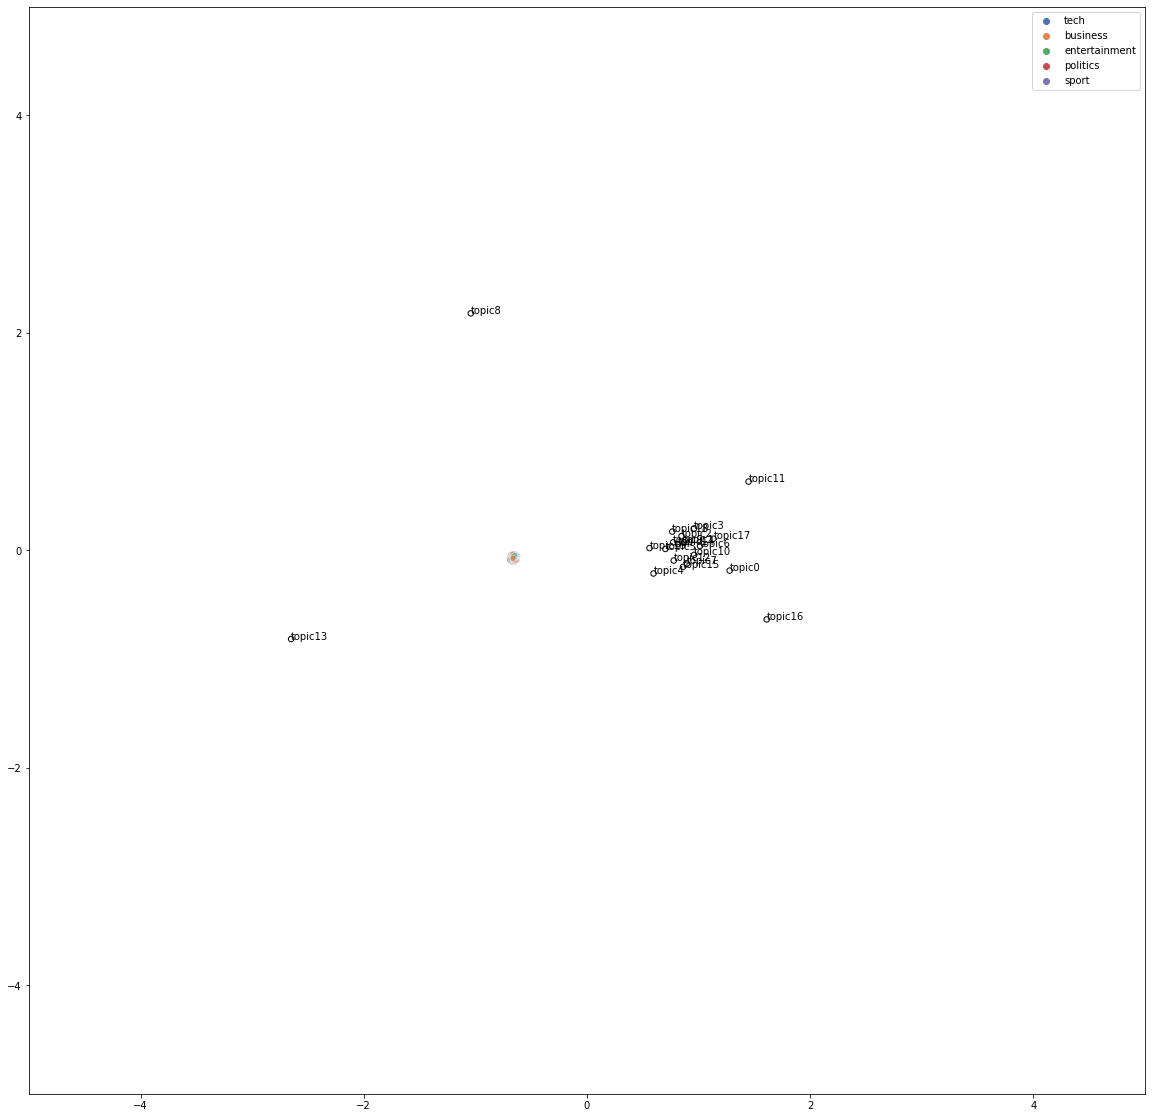

In [ ]:
# Visualization
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-5,5) ,contour='No')

# Stop Here!!

In [ ]:
Stop here!!

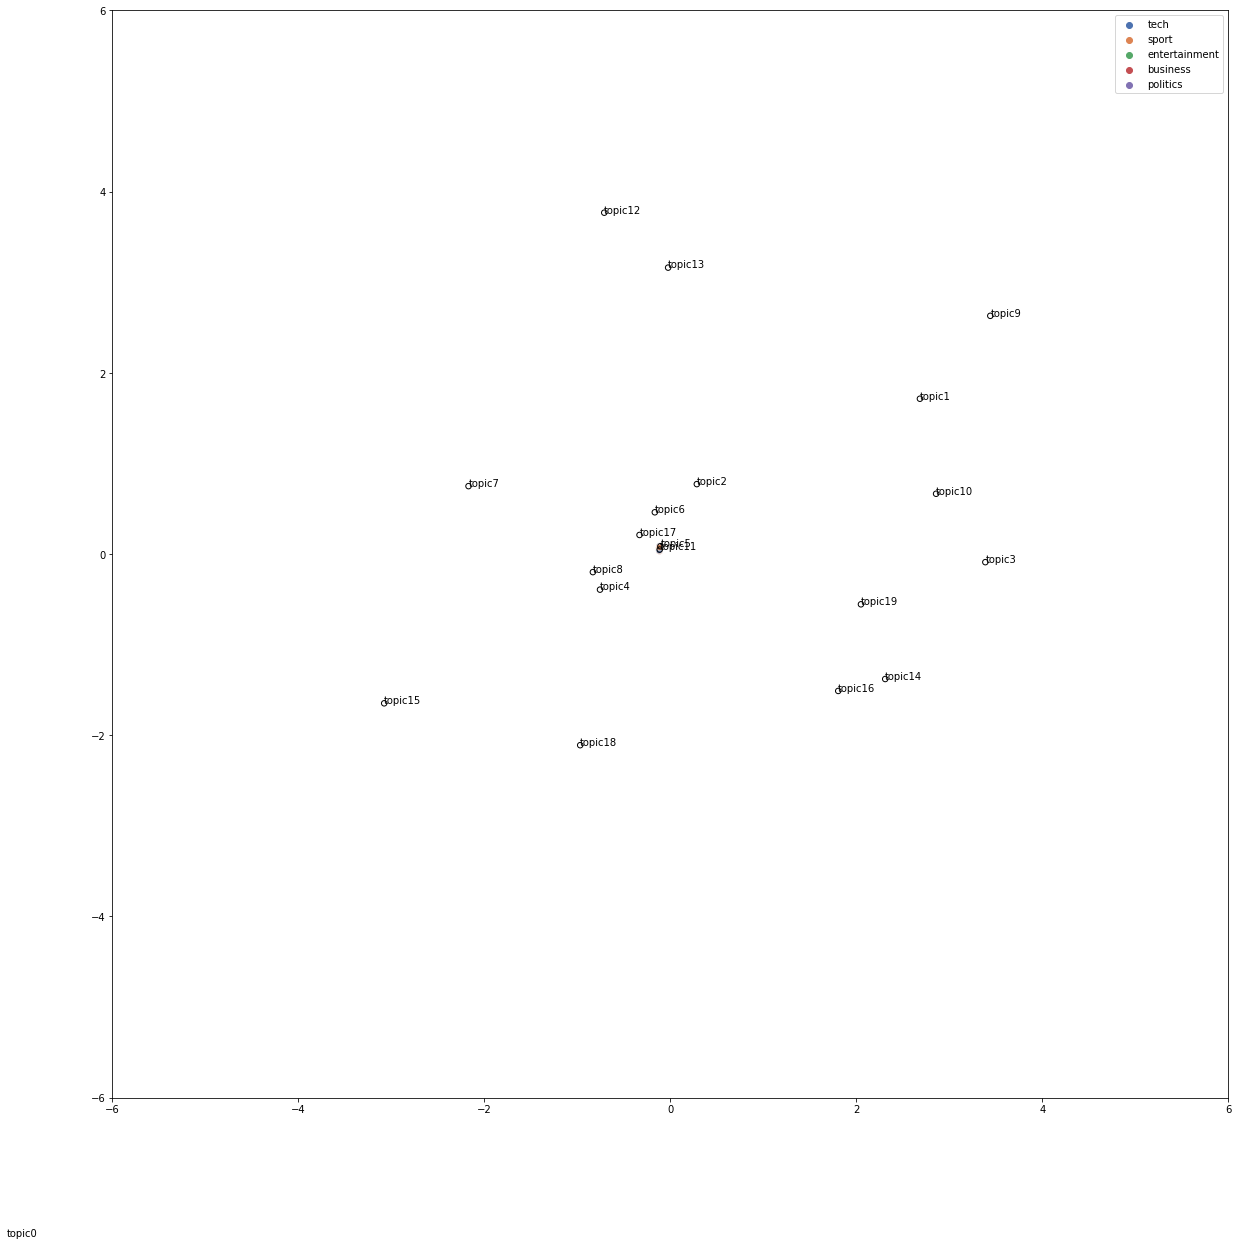

In [ ]:
# Visualization
# ,dropout_rate=0.0,targeted_portion=0.0, avg_test = 1.0 , kw=1
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-6,6) ,contour='No')

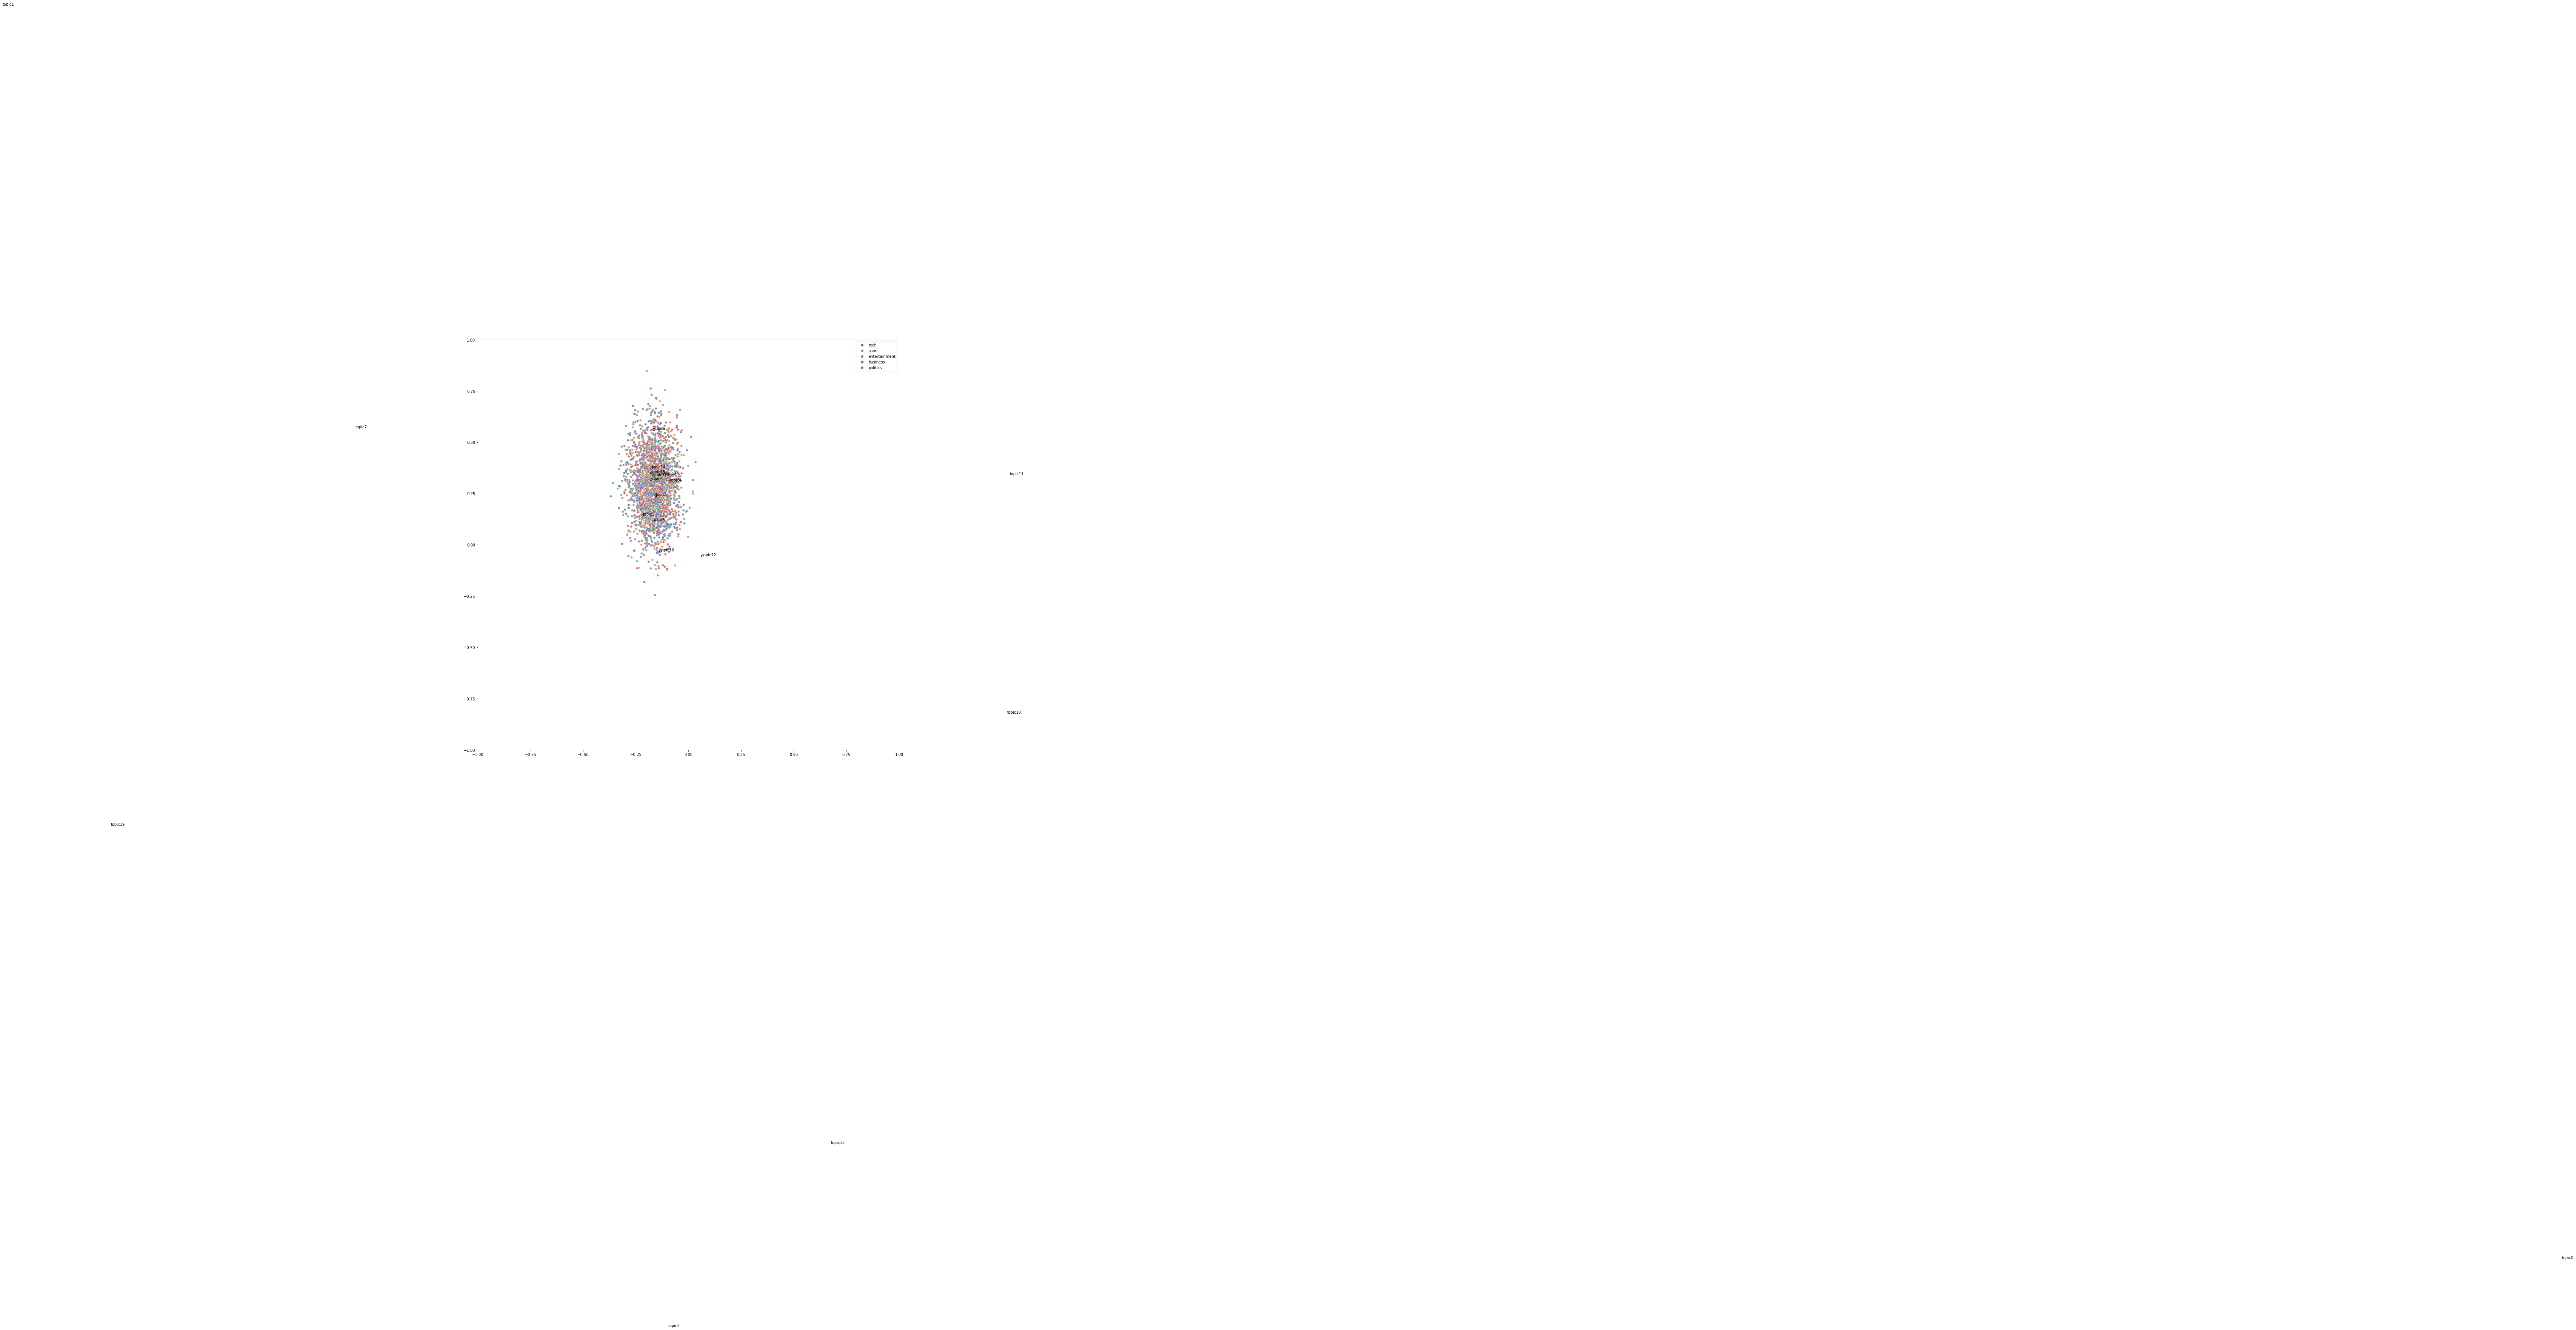

In [ ]:
# Visualization
# ,dropout_rate=0.9,targeted_portion=0.9 , avg_test = 1.0 , kw=1
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-1,1) ,contour='No')

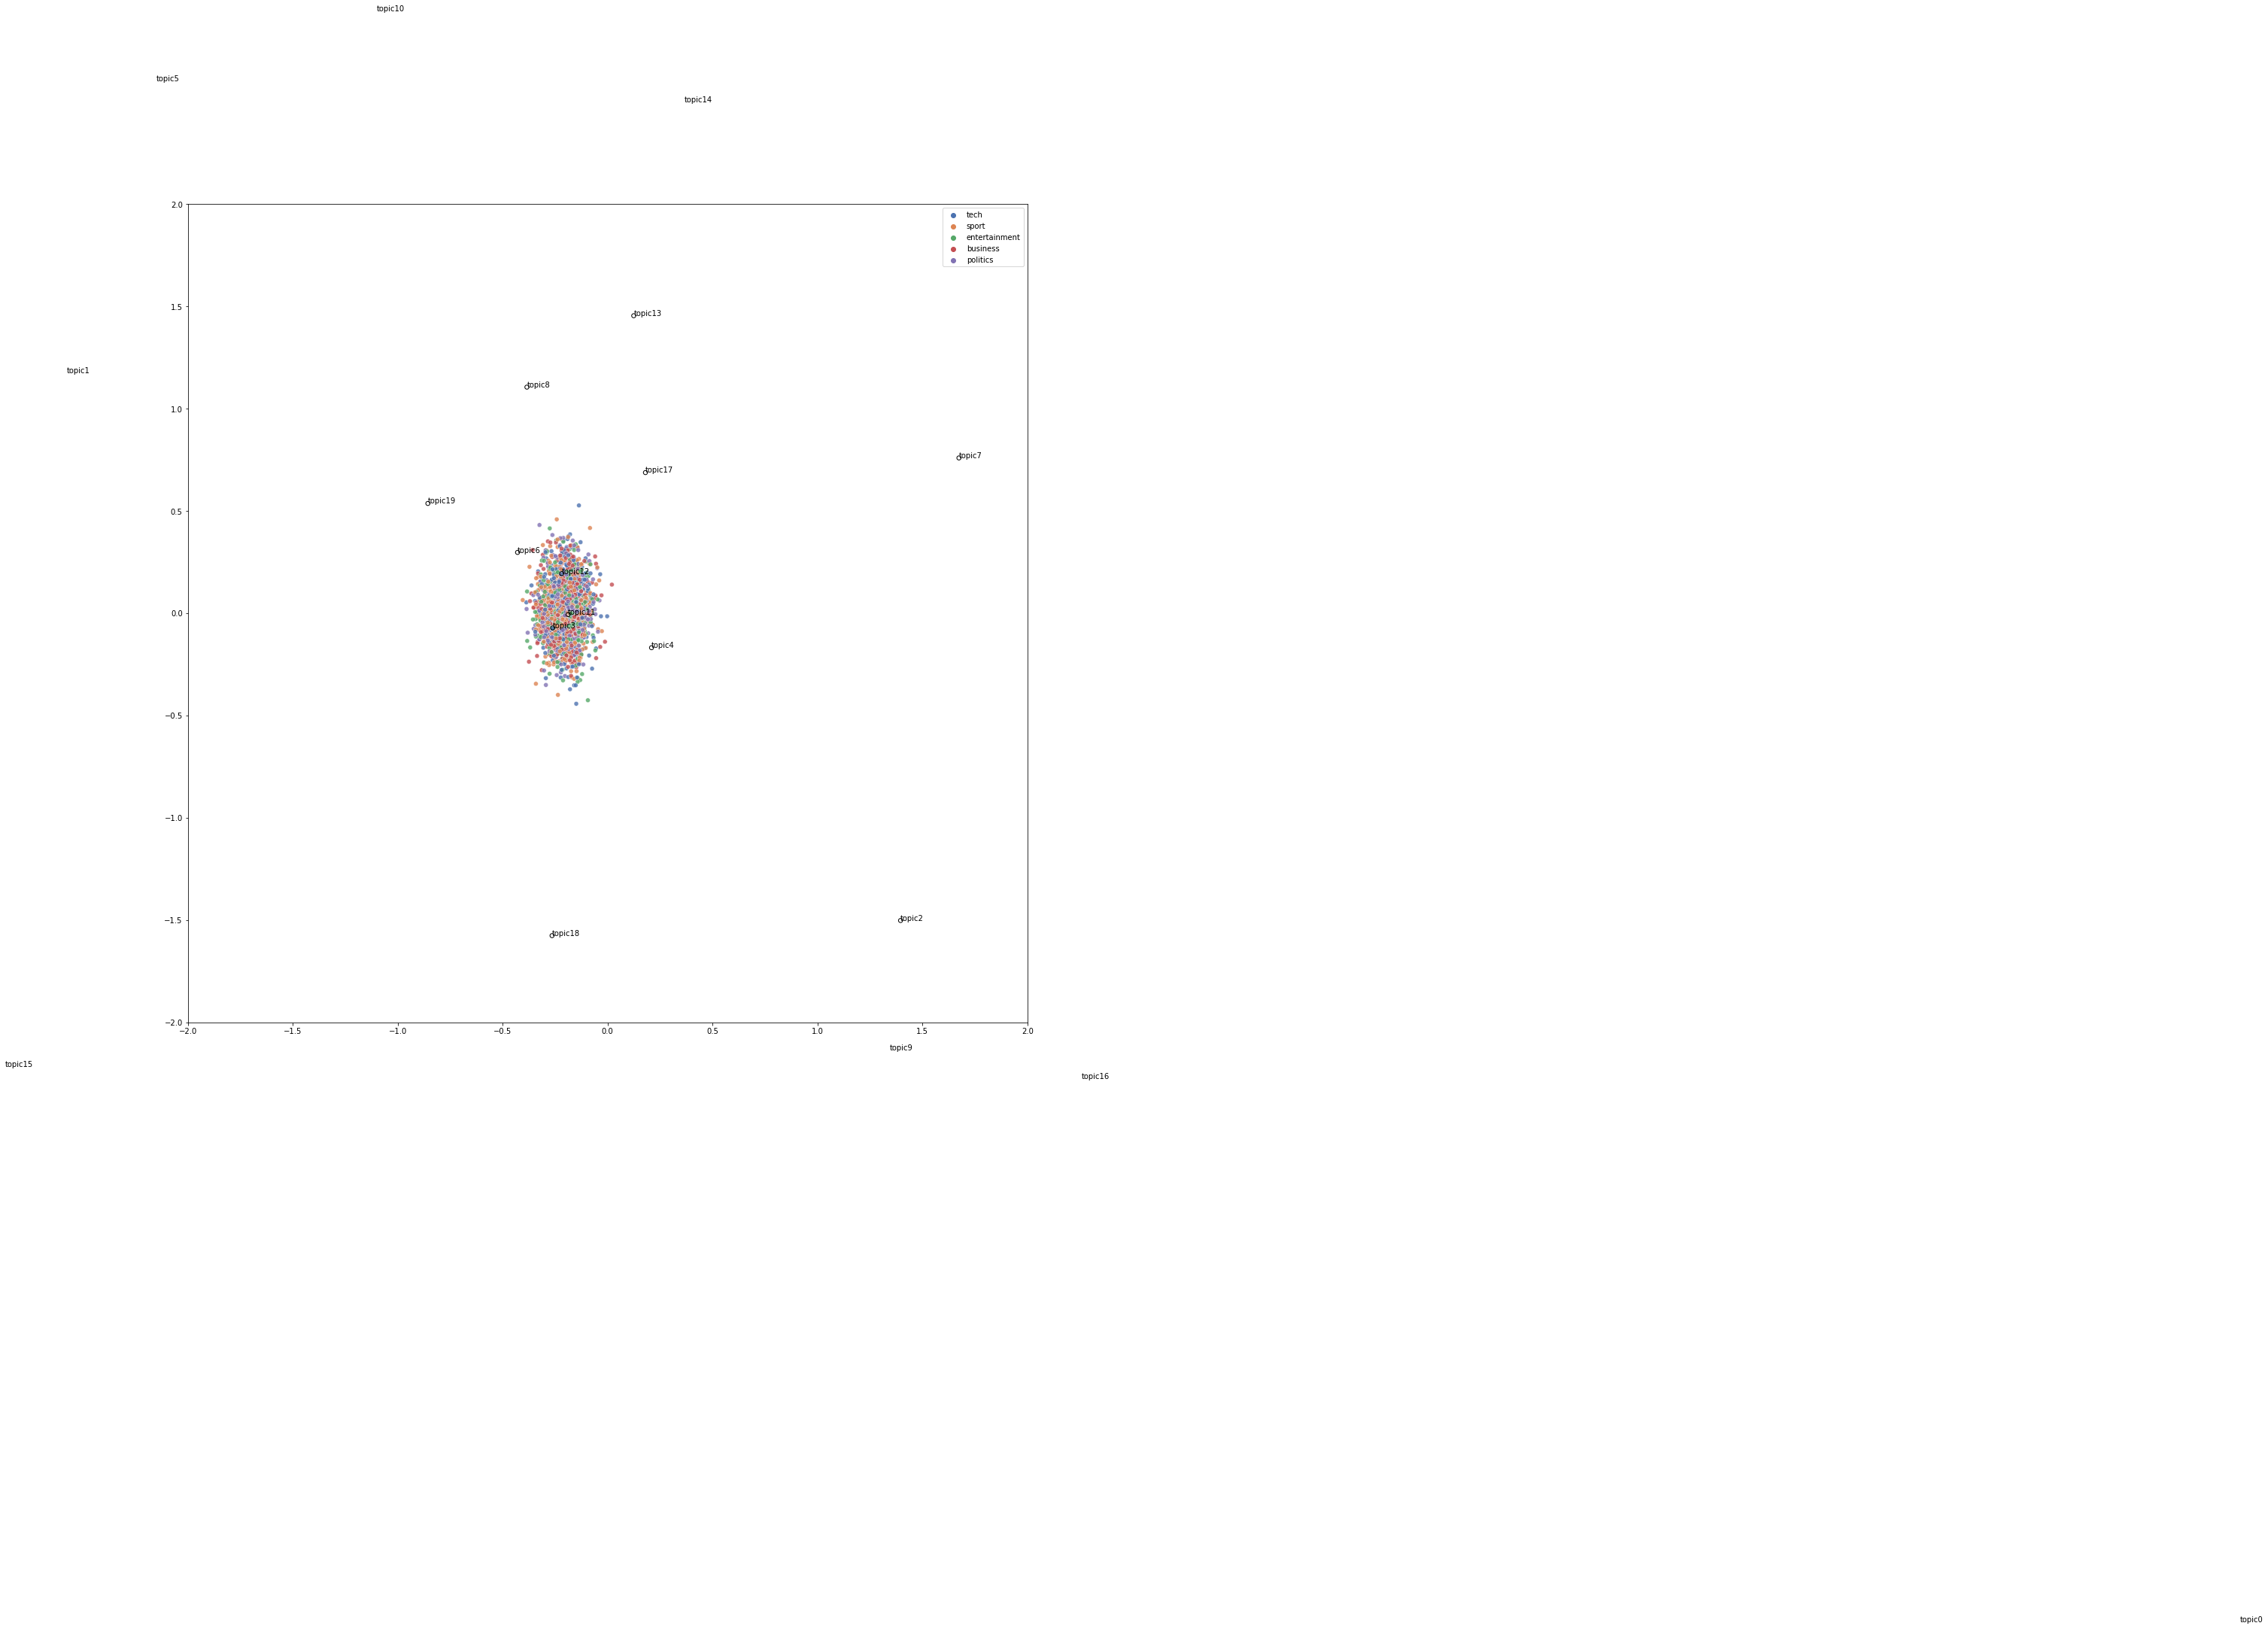

In [ ]:
# Visualization
# ,dropout_rate=0.9,targeted_portion=0.9 , avg_test = 0.001 , kw=1
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-2,2) ,contour='No')

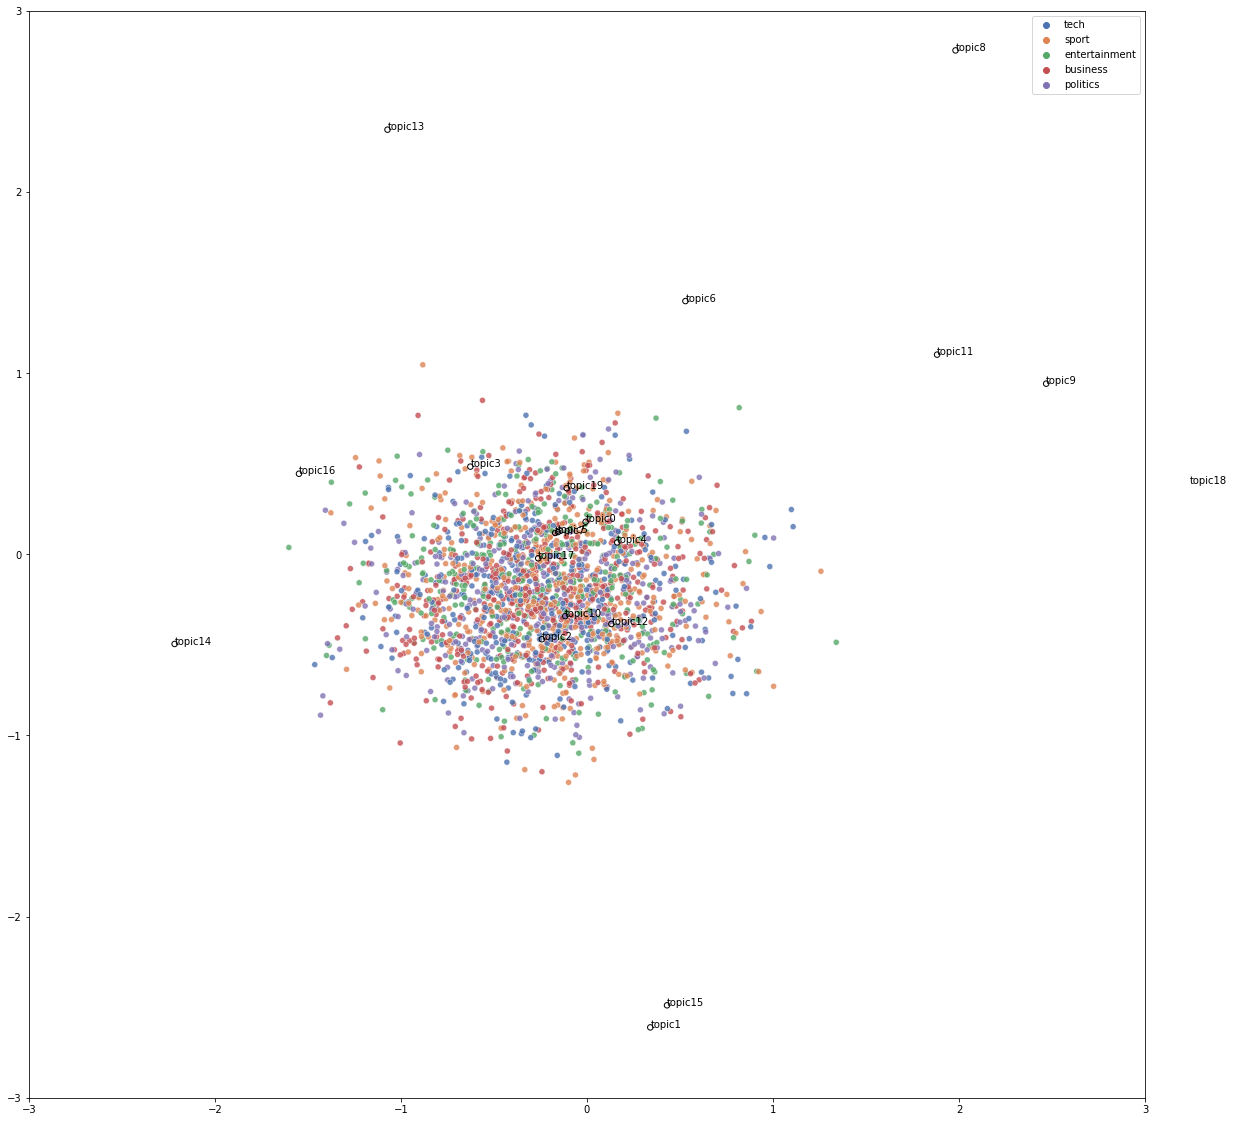

In [ ]:
# Visualization
# ,dropout_rate=0.9,targeted_portion=0.9 , avg_test = 0.001
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-3,3) ,contour='No')

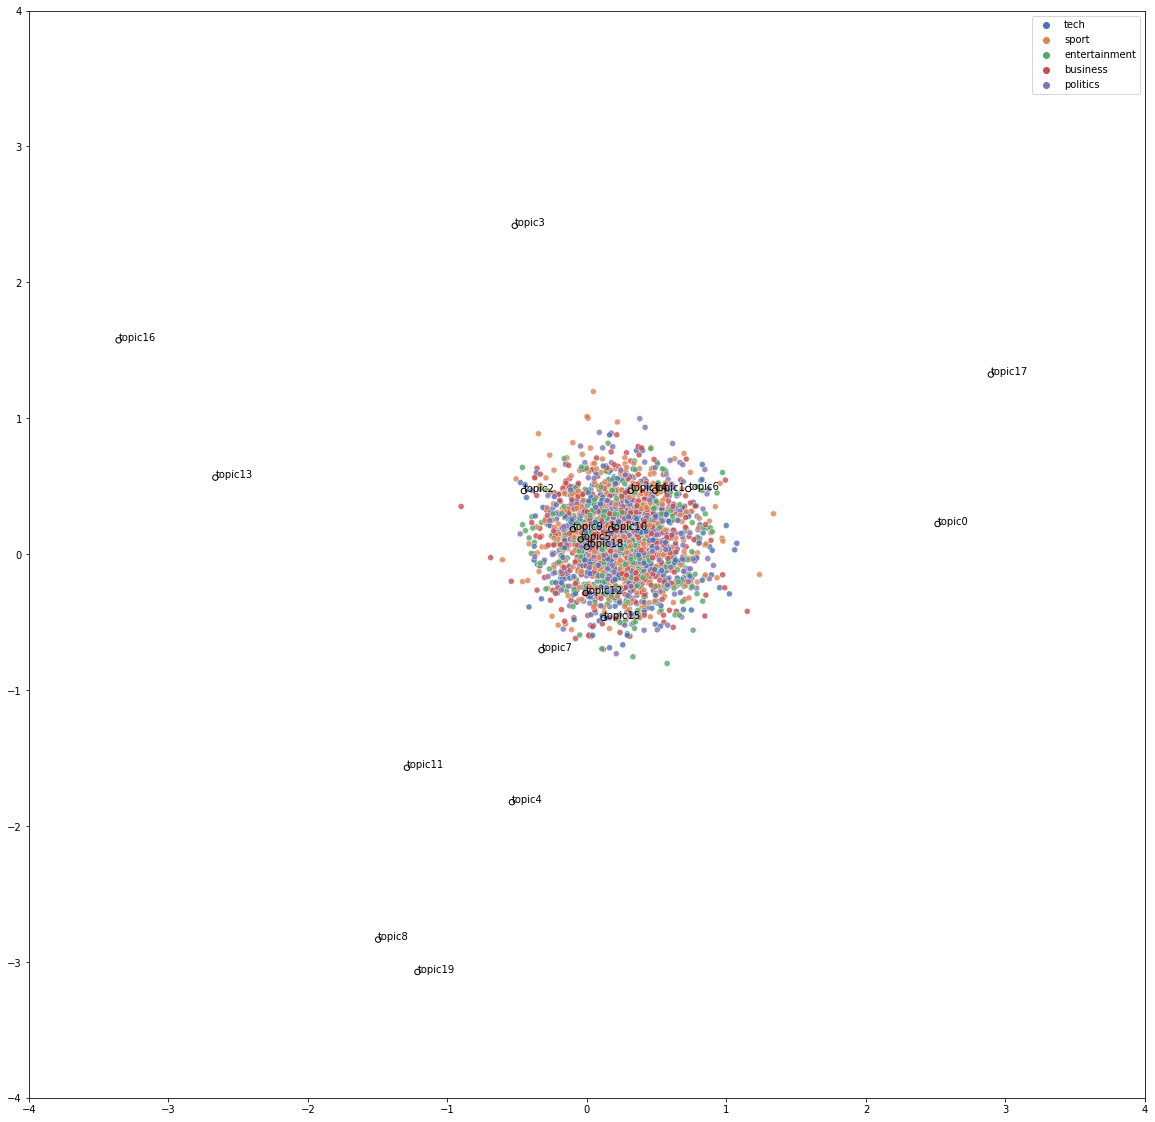

In [ ]:
# Visualization
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-4,4) ,contour='No')

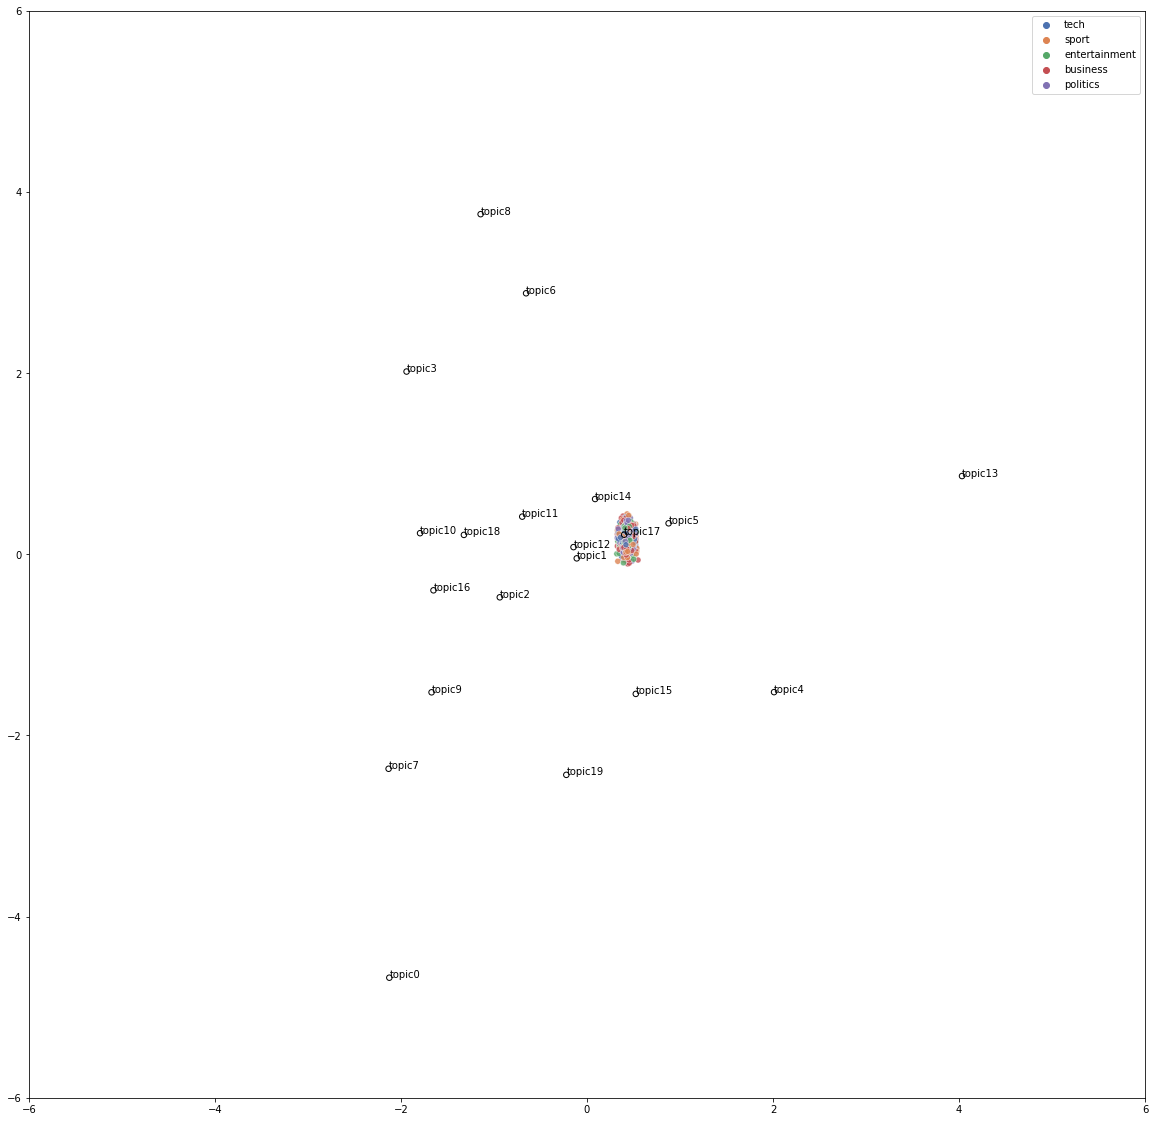

In [ ]:
# Visualization
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-6,6) ,contour='No')

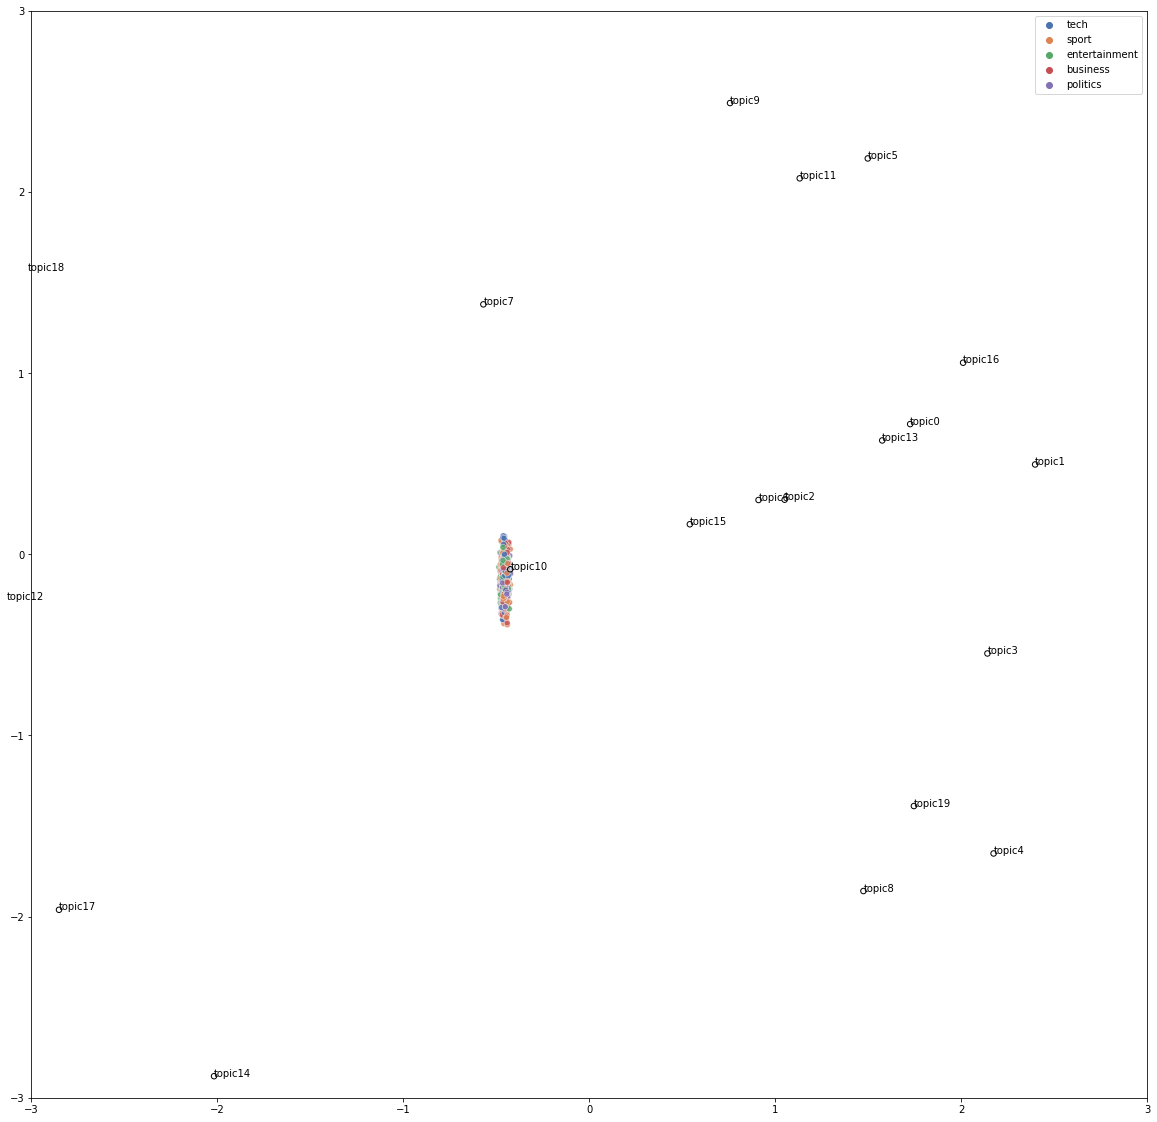

In [ ]:
# Visualization
plot_fig(x_list, labels_list, zphi,query_center=0.0,lim = (-3,3) ,contour='No')

# Download pickle from Dropbox (Documents) - No Need to Run

In [ ]:
!wget https://www.dropbox.com/s/jyiyte9vmkwojee/50_embeddings_load_20news_docs.pkl
#!wget https://www.dropbox.com/s/py3j67m5jnzmqlt/50_docs_preprocessed.pkl
#!wget https://www.dropbox.com/s/j5vex21bdcfhaqy/50_docs_labels.pkl

In [ ]:
# !wget https://www.dropbox.com/s/9v5ar9xu2dv4e04/data_twentynews_preprocessed.pkl
# !wget https://www.dropbox.com/s/09y9y1h0xk3cxaj/embeddings_twentynews.pkl
# !wget https://www.dropbox.com/s/ewv3vcwgll0r8a7/data_twentynews_labels.pkl
# !wget https://www.dropbox.com/s/chpjn9lzr7rmn2k/fixed_data_twentynews_preprocessed.pkl

In [ ]:
# !wget https://www.dropbox.com/s/8khmuj31il8zgkp/data_reuters_labels.pkl
# !wget https://www.dropbox.com/s/bgc1ht0jsyjed6s/embeddings_reuters.pkl
# !wget https://www.dropbox.com/s/9fk30bjzeefvhgl/data_reuters_preprocessed.pkl

In [ ]:
# !wget https://www.dropbox.com/s/52eoulcm5807npk/data_arxiv_preprocessed.pkl
# !wget https://www.dropbox.com/s/zgjy9575pcj5v67/embeddings_arxiv.pkl
# !wget https://www.dropbox.com/s/xzvshpgvwiy3spz/data_arxiv_labels.pkl

In [ ]:
# !wget https://www.dropbox.com/s/c6wlr148lhwsbaz/embeddings_wos.pkl
# !wget https://www.dropbox.com/s/j96061ln6oeejkf/data_wos_preprocessed.pkl
# !wget https://www.dropbox.com/s/kiffa4nidkjt7wi/data_wos_labels.pkl

In [ ]:
# !wget https://www.dropbox.com/s/wz88fk42r0viqvo/data_webkb_preprocessed.pkl
# !wget https://www.dropbox.com/s/8oi5qactwrar1ad/data_webkb_labels.pkl
# !wget https://www.dropbox.com/s/go7r4h39q6l01d5/embeddings_webkb.pkl

#Data preprocessing (No need to run)

In [ ]:
#@title Download Stopwords , punkt, wordnet
import nltk
# nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#@title Imports
import torch
import pandas as pd
from torch import nn
import re
from time import time
import numpy as np
import collections
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
#@title preprocessing non-stem
import sklearn
import re
import string
from numpy import random
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# stem = PorterStemmer()
wnl = WordNetLemmatizer()
stopwords = ['cant','better','well','going','will','would','know','dont','get','like','think','im',"also","said","a", "able", "about", "above", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "after", "afterwards", "again", "against", "ah", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "auth", "available", "away", "awfully", "b", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "between", "beyond", "biol", "both", "brief", "briefly", "but", "by", "c", "ca", "came", "can", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "could", "couldnt", "d", "date", "did", "didn't", "different", "do", "does", "doesn't", "doing", "done", "don't", "down", "downwards", "due", "during", "e", "each", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "et-al", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "few", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "for", "former", "formerly", "forth", "found", "four", "from", "further", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "had", "happens", "hardly", "has", "hasn't", "have", "haven't", "having", "he", "hed", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "hes", "hi", "hid", "him", "himself", "his", "hither", "home", "how", "howbeit", "however", "hundred", "i", "id", "ie", "if", "i'll", "im", "immediate", "immediately", "importance", "important", "in", "inc", "indeed", "index", "information", "instead", "into", "invention", "inward", "is", "isn't", "it", "itd", "it'll", "its", "itself", "i've", "j", "just", "k", "keep  keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "m", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "more", "moreover", "most", "mostly", "mr", "mrs", "much", "mug", "must", "my", "myself", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "now", "nowhere", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "omitted", "on", "once", "one", "ones", "only", "onto", "or", "ord", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "s", "said", "same", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "she", "shed", "she'll", "shes", "should", "shouldn't", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure    t", "take", "taken", "taking", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'll", "theyre", "they've", "think", "this", "those", "thou", "though", "thoughh", "thousand", "throug", "through", "throughout", "thru", "thus", "til", "tip", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "very", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "was", "wasnt", "way", "we", "wed", "welcome", "we'll", "went", "were", "werent", "we've", "what", "whatever", "what'll", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "whose", "why", "widely", "willing", "wish", "with", "within", "without", "wont", "words", "world", "would", "wouldnt", "www", "x", "y", "yes", "yet", "you", "youd", "you'll", "your", "youre", "yours", "yourself", "yourselves", "you've", "z", "zero"]

def preprocessing_nonstem(doc,word2vec_model,my_punctuation):
    # print(doc)
    # word_vectors = word2vec_model.wv
    doc = doc.lower()
    # print(doc)
    doc = doc.translate(str.maketrans('', '', my_punctuation))
    doc = word_tokenize(doc)
    doc = filter(lambda x: x not in my_punctuation, doc)
    # doc = filter(lambda x:x not in stopwords, doc)
    doc = filter(lambda x:not x.isdigit(), doc)
    doc = [wnl.lemmatize(w.lower()) for w in doc]
    # doc = filter(lambda x: x in word2vec_model.vocab,doc)
    doc = filter(lambda x:x not in stopwords, doc)
    doc = filter(lambda x: x in word2vec_model.vocab or x in ".",doc)
    # doc = filter(lambda x:x not in stopwords, doc)
    doc = ' '.join(e for e in doc)
    return doc

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz
from gensim import models
word2vec_model = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#@title function : load / save pickle_obj
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
def get_bbc_data():

  import os
  import glob
  os.system('wget https://www.dropbox.com/s/vunli21d312x55g/bbc.zip')
  os.system('wget https://www.dropbox.com/s/h6y9zfdb76gl4uz/bbc-fulltext.zip')
  os.system('unzip bbc.zip')
  os.system('unzip bbc-fulltext.zip')

  # BBC Docs -
  corpus = []
  subfolders = [f.path for f in os.scandir(os.getcwd()+'/bbc') if f.is_dir()]
  subfolders = sorted(subfolders)
  for s in subfolders:
    files_list = sorted(glob.glob(s+"/*.txt"))
    for file in files_list:
      with open(file, "rb") as f:
        content = f.readlines()
        content = [x.strip().lower().decode('ISO-8859-1') for x in content]
        corpus.append(''.join(content))

  # BBC_labels -
  with open("bbc.classes", "r") as f:
    content = f.readlines()
    content = [x.strip()[::-1][0] for x in content]
    labels = content[4:]
    label_dict = {'0':'business','1':'entertainment','2':'politics','3':'sport','4':'tech'}
  for l in range(len(labels)):
    labels[l] = label_dict[labels[l]]

  return corpus,labels

In [ ]:
docs,labels = get_bbc_data()
len(docs),len(labels)

(2225, 2225)

In [ ]:
list(zip(*np.unique(labels, return_counts=True)))

[('business', 510),
 ('entertainment', 386),
 ('politics', 417),
 ('sport', 511),
 ('tech', 401)]

In [ ]:
dots = [(". "*k).strip() for k in range(1,100)]
def docs_labels_preprocessing(docs,labels,word2vec_model,my_punctuation):
  data_preprocessed = []
  data_preprocessed_labels = []
  for i in range(len(docs)):
    doc = preprocessing_nonstem(docs[i],word2vec_model,my_punctuation)
    # doc[i] = docs[i].replace(".","")
    if(doc!='' and (doc not in dots)):
      data_preprocessed.append(doc)
      data_preprocessed_labels.append(labels[i])
  return data_preprocessed,data_preprocessed_labels

def docs_sentences_labels_preprocessing(docs,labels,word2vec_model):
  doc_preprocessed = []
  doc_preprocessed_labels = []
  sen_preprocessed = []
  doc_id_sent = []
  for i in range(len(docs)):
    if(i%1000==0): print(i)
    doc = ''
    sen_list = nltk.tokenize.sent_tokenize(docs[i])
    for j in sen_list:
      sen = preprocessing_nonstem(j,word2vec_model,string.punctuation)
      if(sen!='' and (sen not in dots)):
        sen_preprocessed.append(sen)
        doc_id_sent.append(len(doc_preprocessed))
        doc = doc + ' ' + sen
    if(doc!='' and (doc not in dots)):
      doc_preprocessed.append(doc)
      doc_preprocessed_labels.append(labels[i])
  return doc_preprocessed,doc_preprocessed_labels,sen_preprocessed,doc_id_sent

In [ ]:
doc_preprocessed,doc_preprocessed_labels,sen_preprocessed,doc_id_sent=docs_sentences_labels_preprocessing(docs,labels,word2vec_model)
# save_obj(doc_preprocessed,'doc_preprocessed')
# save_obj(doc_preprocessed_labels, 'doc_preprocessed_labels')
# save_obj(sen_preprocessed,'sen_preprocessed')
# save_obj(doc_id_sent,'doc_id_sent')

In [ ]:
def create_doc_sentences(doc_id_sent):
  doc_sentences = []
  num_doc = max(doc_id_sent)+1
  for i in range(num_doc):
    if(i%1000==0):
      print(i)
    indices = [j for j, x in enumerate(doc_id_sent) if x == i]
    doc_sentences.append(indices)
  return doc_sentences

def preprocessed_data(sens, docs, labels, word2vec_model):
  vectorizer = CountVectorizer(max_features=5000,dtype=np.float32)
  train_vec = vectorizer.fit_transform(sens).toarray()
  vocab = vectorizer.vocabulary_
  nonzeros_indexes = np.where(train_vec.any(1))[0]
  train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]
  sens_non_zeros = [sens[i] for i in nonzeros_indexes]
  doc_sent_id_non_zeroes = [doc_id_sent[i] for i in nonzeros_indexes]

  train_label =[]
  keep_docs = []
  doc_preprocessed_nonzeroes = []

  for i in doc_sent_id_non_zeroes:
    if(i not in keep_docs):
      keep_docs.append(i)
  for i,j in enumerate(keep_docs):
    if(i%1000==0): print(i)
    doc_preprocessed_nonzeroes.append(doc_preprocessed[j])
    train_label.append(labels[j])

    for k,l in enumerate(doc_sent_id_non_zeroes):
      if(l==j): doc_sent_id_non_zeroes[k]=i

  embeddings = {}
  for f in vocab:
    embeddings[f] = word2vec_model[f]

  save_obj(embeddings,'embeddings')
  save_obj(doc_sent_id_non_zeroes, 'doc_id_sent_nonzeros')
  save_obj(doc_preprocessed_nonzeroes,'doc_preprocessed_nonzeroes')
  save_obj(train_label,'doc_preprocessed_nonzeroes_labels')
  save_obj(sens_non_zeros, 'sen_preprocessed_nonzeroes')
  save_obj(train_vec, 'train_vec')
  save_obj(train_vec_non_zeros, 'train_vec_non_zeros')
  save_obj(vocab, 'vocab')
  return sens_non_zeros, train_label, train_vec_non_zeros, vocab, doc_sent_id_non_zeroes, embeddings

In [ ]:
import gc
sens_non_zeros, train_label, train_vec_non_zeros, vocab, doc_sent_id_non_zeroes, embeddings = preprocessed_data(sen_preprocessed,doc_preprocessed,doc_preprocessed_labels,word2vec_model)
doc_sentences = create_doc_sentences(doc_sent_id_non_zeroes)
save_obj(doc_sentences,'doc_sentences')
gc.collect()

In [ ]:
# len(doc_sent_id_non_zeroes), doc_sentences[-1][-1]+1

In [ ]:
!zip data_bbc.zip *.pkl

In [ ]:
# !zip train_vec.zip train_vec.pkl
# !zip train_vec_non_zeros.zip train_vec_non_zeros.pkl

In [ ]:
from google.colab import files
files.download("data_bbc.zip")

In [ ]:
Score Not Used Anymore

In [ ]:
def cosine_similarity_desm_docs(query_list, train_vec, vocab, embeddings):
  num_docs = len(train_vec)
  num_voc = len(vocab)
  sim_list = torch.zeros(num_docs)
  index = 0
  id_vocab = dict(map(reversed, vocab.items()))
  for d in range(num_docs):
    if(d%5000==0): print(d)
    doc_bar = torch.zeros(300)
    doc_length = 0
    for v in range(num_voc):
      if(train_vec[d][v]>0):
        doc_bar.add_(train_vec[d][v] * torch.from_numpy(embeddings[id_vocab[v]])/torch.norm(torch.from_numpy(embeddings[id_vocab[v]])))
        doc_length = doc_length + train_vec[d][v]
    doc_bar = doc_bar / doc_length
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list

In [ ]:
keywords = get_keywords()
all_rscores = cosine_similarity_desm_docs(keywords, train_vec_non_zeros, vocab, embeddings)
save_obj(all_rscores, 'all_rscores')

# Download pickle from Dropbox (50 Sentences)

In [ ]:
# !wget https://www.dropbox.com/s/408eefyszxnadke/50_data_load_20news_sentences_labels.pkl
# !wget https://www.dropbox.com/s/hqq00bqababxovo/50_data_load_20news_sentences_preprocessed.pkl
# !wget https://www.dropbox.com/s/e63a0ew3y7ktz17/50_doc_id_sent_load_20news_sentences.pkl

#Testing - No Need to Run

In [ ]:
#@title All variables occupying memory
import sys
local_vars = list(locals().items())
sum = 0
for var, obj in local_vars:
    #sum = sum + sys.getsizeof(obj)/1e9
    print(var, sys.getsizeof(obj)/1e9)
print(sum)

In [ ]:
#@title Variables occupying large amt of mem
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

#Normalized all_rscores(DESM) (Not Used)

In [ ]:
# torch.max(all_rscores)
# keywords = get_keywords()
# top_10_docs=[]
# sort,indices = torch.sort(all_rscores,descending=True)
# print('Keywords',get_keywords())
# print('Descending :',sort,'\n','indices:',indices)
# print('\n\n Top 10 Relevant Documents (DESM):\n\n',"---"*40)

# for k in range(10):
#     print(k+1,') ',sen_preprocessed[indices[k].item()])
#     print(k+1,')',doc_preprocessed_labels[doc_id_sent[indices[k].item()]])
# with open("1000.txt", "w") as output:
#   for k in range(0,1000):
#     output.write(str(k+1)+')  '+sen_preprocessed[indices[k].item()]+'\n')
#     output.write(str(k+1)+')  '+str(sort[indices[k].item()].item())+'\n')
#     output.write(str(k+1)+')  '+doc_preprocessed_labels[doc_id_sent[indices[k].item()]]+'\n\n')

#     # print(k+1,') ',preprossed_data_non_zeros[indices[k].item()])
#     # print(k+1,')',train_label[indices[k].item()])
#     # print()

# output.close()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from matplotlib import pyplot as plt
# scaler = MinMaxScaler(feature_range=(0+1e-10, 0.99))
# normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
# normalized_all_rscores=torch.tensor(normalized_all_rscores.flatten())
# rounded_normalized_all_rscores = torch.round(normalized_all_rscores*10)/10.0

In [ ]:
# plt.hist(all_rscores)

In [ ]:
# plt.hist(rounded_normalized_all_rscores)

In [ ]:
# r_origin = rounded_normalized_all_rscores

In [ ]:
# r_origin.shape

In [ ]:
# for i in range(len(rounded_normalized_all_rscores)):
#     for k in keywords:
#       if (k in sen_preprocessed[i]):
#         rounded_normalized_all_rscores[i] = 1.0

In [ ]:
# for i in range(len(normalized_all_rscores)):
#     for k in keywords:
#       if (k in sen_preprocessed[i]):
#         normalized_all_rscores[i] = 1.0

In [ ]:
# plt.hist(rounded_normalized_all_rscores)

#Create Relvance Vector(Bernoulli_v1)

In [ ]:
# def padarray(A, size,criteria):
#     A = list(A)
#     if criteria=='top':
#       A[::-1].sort()
#     elif criteria=='first':
#       pass
#     t = size - len(A)
#     if t<=0:
#       return A[:size]
#     else:
#       # return np.pad(A, irrelv_vector, mode='constant')
#       for _ in range(t):
#         A.append([0 for _ in range(num_topic)])
#       return A

In [ ]:
# irrelv_vector = [0 for _ in range(num_topic)]
# relv_vector = [1 for _ in range(num_topic)]

# # Bernoulli f(k;p) = p(k) + (1-p)(1-k) for k={0,1}
# # for both k = 0 or k = 1 : if p = 0.5 --> f(k;p) = 0.5
# irrelv_vector[0] = 0.5
# relv_vector[0] = 0.5

# # Without bernoulli
# # irrelv_vector[0] = 1
# # relv_vector[0] = 0

# relv_score_vector = []
# keys  = get_keywords()

# for s in sen_preprocessed:
#   key_indicator = 0
#   for k in keys:
#     # if k in s:
#     if re.search(r'\b' + k + r'\b', s):
#       key_indicator = 1
#       relv_score_vector.append(relv_vector)
#       break
#   if key_indicator == 0:
#     relv_score_vector.append(irrelv_vector)

# relv_score_vector =np.array(relv_score_vector)
# score = [relv_score_vector[i] for i in doc_sentences]

In [ ]:
# # rounded_list = rounded_normalized_all_rscores.numpy()
# for i in range(len(score)):
#   score[i] = padarray(score[i],50,'first')
# score_all_doc_s_n = torch.tensor(np.array(score))

In [ ]:
# status_all_doc_s_n = torch.zeros(score_all_doc_s_n.size())
# for score in range(score_all_doc_s_n.shape[0]):
#   for st in range(score_all_doc_s_n.shape[1]):
#     if score_all_doc_s_n[score][st]>torch.tensor(0.0):
#       status_all_doc_s_n[score][st] = torch.tensor(1.0,dtype=torch.float64)

# Dists, Sigmoid, Old Model (No need to Run)

Other Distributions
(Beta, Gaussian, Raised Cosine) etc..

In [ ]:
# @title
# def beta(x,mu,a):
#   smoothen=1e-20
#   b = (a - a * (mu+smoothen))/(mu+smoothen)
#   # a = (b * (mu+smoothen))/((1-mu)+smoothen)
#   deno = (torch.lgamma(a)+torch.lgamma(b)-torch.lgamma(a+b))
#   ret = (a-1)*torch.log(x) + (b-1)*torch.log(1-x)-deno
#   return ret

# def log_gaussian(x,mu,variance):
#   pi = 3.1415927410125732
#   ret = -0.5 * ((x-mu)/variance)**2 - torch.log(variance*(2*pi)**0.5)
#   return ret

# def raised_cosine(x,mu,s):
#   #torch.pi = torch.acos(torch.zeros(1)).item() * 2
#   pi = 3.1415927410125732

#   check_range = (x > mu-s) & (x < mu+s)
#   a = 1.0 / 2*s
#   c = (x - mu) / s
#   b = torch.cos(pi * c)
#   raised_cosine = a*(1+b)

#   raised_cosine = raised_cosine * check_range

#   return raised_cosine

# def LogL_Score_beta(theta,phi,torch_sim):
#   # s_rc=1
#   # phi_z = torch.norm(phi,dim=-1).unsqueeze(-1) #num_topic --> 50
#   # R_phi = torch.exp(-0.5 * (torch.pow(phi_z,2))) # ---> 50 x 1
#   # mu = torch.matmul(theta,R_phi) # bs x num_topic * num_topicx1
#   # LogL = torch.log(raised_cosine(torch_sim, mu, s_rc)+1e-20)
#   #b=torch.tensor(100.0)
#   # a=torch.tensor(100.0)

#   phi_z = torch.norm(phi,dim=-1).unsqueeze(-1) #num_topic --> 50
#   R_phi = torch.exp(-0.5 * (torch.pow(phi_z,2))/100.0 ) # ---> 50 x 1
#   mu = torch.matmul(theta,R_phi) # bs x num_topic * num_topicx1
#   LogL = beta(torch_sim, mu, a)
#   return LogL.sum()

# def LogL_Score(x,torch_sim):
#   x=x.squeeze(-2)
#   variance=torch.tensor(0.1)
#   x_norm = torch.norm(x,dim=-1)
#   mu = torch.exp(-0.5 * (torch.pow(x_norm,2)))
#   LogL = log_gaussian(torch_sim, mu, variance)
#   #LogL = beta(torch_sim, mu, b)
#   return LogL.sum()

# # def LogL_Score_test(zx,relevant_scores):
# #   x_norm = torch.norm(zx,dim=-1)
# #   NegativeLogL_RScore = 10000 * torch.exp(-0.5 * (torch.pow(x_norm,2)/100.0) - relevant_scores)**2
# #   return NegativeLogL_RScore.sum()


# def LogL_Score_current(theta,phi,relevant_scores):
#   a=torch.tensor(100.0)
#   phi_z = torch.norm(phi,dim=-1).unsqueeze(-1)
#   R_phi = torch.exp(-0.5 * (torch.pow(phi_z,2)))

#   R_n = torch.pow(theta,R_phi)

#   LogL = beta(torch_sim, mu, a)
#   return LogL.sum()

In [ ]:
#@title Reverse Sigmoid Function
import matplotlib.pylab as plt
import numpy as np
var = -0.5 # change this to -1.0, -1.5 , -2.0
x = np.arange(-8, 8, 0.1)
y = np.exp(var*x) / (1 + np.exp(var*x))

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
#@title Truncated Normal , Beta ..
# def inv_S(r,a,c,D,smoothen):
#   numr = 1-c
#   deno = 1+ torch.exp(a * ( (2*r)/D - 1))
#   invS = numr / (deno + smoothen) + c
#   return invS

# def beta(x,mu,a):
#   smoothen=1e-20
#   b = (a - a * (mu+smoothen))/(mu+smoothen)
#   # a = (b * (mu+smoothen))/((1-mu)+smoothen)
#   deno = (torch.lgamma(a)+torch.lgamma(b)-torch.lgamma(a+b))
#   ret = (a-1)*torch.log(x) + (b-1)*torch.log(1-x)-deno
#   return ret

# def truncate_phi(Xi):
#   pi = 3.1415927410125732
#   return (1.0/ ((2.0*pi)**0.5) )*torch.exp(-0.5*(Xi**2))

# def truncate_bold_phi(x):
#   return 0.5 * (1.0 + torch.erf(x / (2.0**0.5)))

# def truncate_norm_dist(x,mu,a,b,sig,smoothen):
#     check_range = (x >= mu-a) & (x <= mu+b)
#     # check_range = (x >= a) & (x<=b)
#     l=(1.0/sig)
#     r_numr= truncate_phi((x-mu)/sig)
#     r_deno= truncate_bold_phi((b-mu)/sig) - truncate_bold_phi((a-mu)/sig)
#     tr_ndist = l*(r_numr/(r_deno+smoothen))
#     #print(tr_ndist)
#     tr_ndist = tr_ndist*check_range
#     #print(tr_ndist)
#     return tr_ndist


# def LogL_Score_TND(theta,phi,relevant_scores, query_center,x):
#   smoothen=1e-20
#   a=1
#   b=1
#   sig=0.01

#    #phi_z = torch.norm(phi,dim=-1).unsqueeze(-1)

#   # phi_z = (phi-query_center.T).pow(2).sum(-1).unsqueeze(-1)
#   # R_phi = torch.exp(-0.5 * (torch.pow(phi_z,2))/mu_div)
#   # mu = torch.prod(R_phi ** theta.T,0)

#   x_norm = (x-query_center.T).pow(2).sum(-1)
#   mu = torch.exp(-0.5 * (x_norm)/mu_div)

#   # x_norm = torch.norm(x,dim=-1)
#   # mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div)

#   # mu = 1.0/(1.0 + (torch.pow(x_norm,2)/mu_div))
#   LogL = torch.log(truncate_norm_dist(relevant_scores, mu, a,b,sig,smoothen)+smoothen)


  # a = torch.tensor(3.0)
  # c = torch.tensor(0.0035)
  # D = torch.tensor(23.0)

  # # LogL = torch.log(inv_S(x_norm,a,c,D,smoothen)+smoothen)
  # return LogL.sum()

In [ ]:
# @title OLD model
# import sklearn
# import pickle
# import torch
# import sys
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# from sympy.stats import RaisedCosine,density
# import torch.nn.functional as F
# import torch.optim as optim
# import numpy as np
# import torch.utils.data as data_utils
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from types import SimpleNamespace
# from torch.nn import Parameter
# torch.cuda.empty_cache()

# mu_div = 1500.0
# gaussian_variance=torch.tensor(0.05)

# def log_gaussian(x,mu,variance):
#    pi = 3.1415927410125732
#    ret = -0.5 * ((x-mu)/variance)**2 - torch.log(variance*(2*pi)**0.5)
#    return ret

# def LogL_gaussianScore(x,relevant_scores,query_center):

#   # x_norm = torch.norm(x,dim=-1)
#   # mu = torch.exp(-0.5 * (torch.pow(x_norm,2))/mu_div )

#   x_norm = (x-query_center.T).pow(2).sum(-1)
#   mu = torch.exp(-0.5 * (x_norm)/mu_div)

#   LogL = log_gaussian(relevant_scores, mu, gaussian_variance)
#   return LogL.sum()
# ############################################################################################


# def gaussian(alpha):
#     # phi = torch.exp(-5*alpha)
#     phi = -0.5*alpha
#     return phi

# def inverse_multi_quadric(alpha):
#     phi = -0.5*torch.log(torch.ones_like(alpha) + alpha)
#     return phi

# def inverse_quadratic(alpha):
#     # phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha)
#     phi = -torch.log(torch.ones_like(alpha) + alpha)
#     return phi

# class PlsvVAE(nn.Module):
#     def __init__(self, num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, distance="gaussian"):
#         super(PlsvVAE, self).__init__()
#         self.num_input, self.num_coordinate, self.num_topic, self.variance_x, self.bs\
#             = num_input, num_coordinate, num_topic, variance_x, bs

#         # encoder
#         self.en1_fc     = nn.Linear(num_input, en1_units_x)             # V -> 100 #nxV->(vxh1)->nxh1;
#         self.en2_fc     = nn.Linear(en1_units_x, en2_units_x)             # 100  -> 100
#         self.en2_drop   = nn.Dropout(drop_rate)
#         self.mean_fc    = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
#         self.mean_bn    = nn.BatchNorm1d(num_coordinate)              # bn for mean
#         self.logvar_fc  = nn.Linear(en2_units_x, num_coordinate)        # 100  -> 2
#         self.logvar_bn  = nn.BatchNorm1d(num_coordinate)              # bn for logvar


#         # RBF
#         self.in_features = self.num_coordinate
#         self.out_features = self.num_topic
#         self.centres = nn.Parameter(torch.Tensor(self.out_features, self.in_features))


#         self.query_center = nn.Parameter(torch.zeros(2,1))

#         if distance=="gaussian":
#             self.basis_func = gaussian
#         if distance=="inverse_quadratic":
#             self.basis_func = inverse_quadratic
#         if distance=="inverse_multi_quadric":
#             self.basis_func = inverse_multi_quadric
#         self.init_parameters()


#         # decoder layer
#         self.decoder    = nn.Linear(self.num_topic, self.num_input)             # 50   -> 1995
#         self.decoder_bn = nn.BatchNorm1d(self.num_topic)                      # bn for decoder

#         # decoder document
#         self.decoder_phi_bn = nn.BatchNorm1d(num_coordinate)                      # bn for decoder
#         self.decoder_x_bn = nn.BatchNorm1d(num_coordinate)

#         # prior mean and variance as constant buffers
#         prior_mean   = torch.Tensor(1, num_coordinate).fill_(0)
#         prior_var    = torch.Tensor(1, num_coordinate).fill_(variance_x)
#         self.prior_mean = nn.Parameter(prior_mean, requires_grad=False)
#         self.prior_var  = nn.Parameter(prior_var, requires_grad=False)
#         self.prior_logvar = nn.Parameter(prior_var.log(), requires_grad=False)


#     def init_parameters(self):
#         nn.init.normal_(self.centres, 0, 0.01)

#     def encode(self, input_):
#         N, *_ = input_.size()
#         # compute posterior
#         en1 = F.softplus(self.en1_fc(input_))                           # en1_fc   output
#         en2 = F.softplus(self.en2_fc(en1))                              # encoder2 output
#         en2 = self.en2_drop(en2)
#         posterior_mean   = self.mean_bn  (self.mean_fc  (en2))          # posterior mean
#         posterior_logvar = self.logvar_bn(self.logvar_fc(en2))          # posterior log variance
#         posterior_var    = posterior_logvar.exp()

#         return en2, posterior_mean, posterior_logvar, posterior_var

#     def take_sample(self, input_, posterior_mean, posterior_var, prior_var):
#         # take sample
#         eps = input_.data.new().resize_as_(posterior_mean.data).normal_(std=1) # noise
#         # N x X
#         z = posterior_mean + posterior_var.sqrt() * eps                   # reparameterization

#         return z

#     def decode(self, z):
#         # decode
#         N, *_ = z.size()
#         zx = self.decoder_x_bn(z).view(N, 1, self.num_coordinate) # Nx1xX

#         # se = self.decoder_x_bn(z).view(N, S, self.num_coordinate) # NxSxV

#         # zx = z.view(N, 1, self.num_coordinate) # Nx1xX

#         size = (N, self.out_features, self.in_features) # N,K,2
#         x = zx.expand(size)
#         c = self.decoder_phi_bn(self.centres).unsqueeze(0).expand(size)
#         # c = self.centres.unsqueeze(0).expand(size)

#         d = (x-c).pow(2).sum(-1)
#         distances = self.basis_func(d) #NxK
#         zx_phi = torch.exp(distances - torch.logsumexp(distances, dim=-1, keepdim=True))

#         ##############
#         c_norm = self.decoder_phi_bn(self.centres).pow(2).sum(-1).unsqueeze(-1)
#         R_phi = torch.exp(-0.5 * c_norm/mu_div)
#         input_sq = input_.unsqueeze(3).expand(256,50,5000,20)
#         ##############

#         recon_v = torch.mm(zx_phi, F.softmax(self.decoder_bn(self.decoder.weight).transpose(1,0), dim=-1))
#         return recon_v, zx, zx_phi, d, c

#     def forward(self, input_, relevant_scores, gpu_n_s_v, compute_loss=False):
#         en2, posterior_mean, posterior_logvar, posterior_var = self.encode(input_)
#         z = self.take_sample(input_, posterior_mean, posterior_var, self.variance_x)

#         # decode
#         recon_v, zx, zx_phi,d,c= self.decode(z)

#         if compute_loss:
#             return recon_v, self.loss(input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d, c, relevant_scores, zx, gpu_n_s_v)
#         else:
#             return z, recon_v, zx, zx_phi


#     def loss(self, input_, recon_v, zx_phi, posterior_mean, posterior_logvar, posterior_var, d, c, relevant_scores, zx, gpu_n_s_v, avg=True):

#         N = posterior_mean.shape[0]
#         L = recon_v.shape[0]
#         NL = - (input_ * (recon_v+1e-10).log()).sum(-1)

# #         N1, *_ = z.size()
# #         size = (N1, self.out_features, self.in_features)
# #         c = self.decoder_phi_bn(self.centres).unsqueeze(0).expand(size)

#         prior_mean   = self.prior_mean.expand_as(posterior_mean)
#         prior_var    = self.prior_var.expand_as(posterior_mean)
#         prior_logvar = self.prior_logvar.expand_as(posterior_mean)

#         var_division    = posterior_var  / prior_var #Nx2
#         diff            = posterior_mean - prior_mean
#         diff_term       = diff * diff / prior_var
#         logvar_division = prior_logvar - posterior_logvar

#         xKLD = 0.5 * ( (var_division + diff_term + logvar_division).sum(-1) - self.num_coordinate)
#         return_xKLD = xKLD.mean(0)
#         KL = return_xKLD

#         # NegativeLogL_RScore = - LogL_Score_beta(zx_phi,self.decoder_phi_bn(self.centres),relevant_scores)
#         # NegativeLogL_RScore = - LogL_Score(zx,relevant_scores)
#         # x_norm = torch.norm(zx,dim=-1)
#         # NegativeLogL_RScore = (100000 * (torch.exp(-0.5 * (torch.pow(x_norm,2)/10.0) - relevant_scores )  )**2  ).sum()
#         # NegativeLogL_RScore = LogL_Score_test(zx,relevant_scores)

#         #NegativeLogL_RScore = - LogL_Score_TND(zx_phi,self.decoder_phi_bn(self.centres),relevant_scores, self.query_center,zx)

#         #NegativeLogL_RScore = - LogL_gaussianScore(zx,relevant_scores,self.query_center)
#         # Final Function

#         NegativeLogL_RScore = - torch.log(sum(R * Z * (W^input_w).prod())).sum()

#         #loss = NL.sum() + KL + NegativeLogL_RScore
#         loss = NL.sum() + KL

#         # print(type(loss))
#         return loss/N, NL.sum(), return_xKLD,  KL

# Extra (WordCloud, Archive TFIDF)

WordCloud



In [ ]:
!pip install wordcloud

In [ ]:
word_list=data_20news_preprocessed[j].split()
print(word_list)
flatten_all_words

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt

comment_words = ''
topic_topword_comment = ''

for val in top_10_docs:
    comment_words += " ".join(val)+" "

for topword_topic in topword_topics_list:
    topic_topword_comment += " ".join(topword_topic)+" "

wordcloud_top10_docs = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

wordcloud_topword_topics = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(topic_topword_comment)

f = plt.figure(1,figsize = (8, 8))
plt.title('Words in Top Relevant 10 Docs')
plt.axis("off")
plt.tight_layout(pad = 3.0)
plt.imshow(wordcloud_top10_docs)
g = plt.figure(2,figsize = (8, 8))
plt.title("Top Words in k topics")
plt.axis("off")
plt.tight_layout(pad = 3.0)
plt.imshow(wordcloud_topword_topics)
plt.show()

Archive

In [ ]:
import plotly.graph_objects as go
epochs=1000
def plot_loss(y,name):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=[i for i in range(1,epochs+1)], y=y,mode='lines',name=name))
  figure.show(renderer='colab')

plot_loss(x_arr,'KLD')
plot_loss(recon_arr,'Recon_loss')
plot_loss(neg_log_rscore_arr,'RScore')

In [ ]:
plt.hist(x=all_rscores.data)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_all_rscores = scaler.fit_transform(all_rscores.data.reshape(-1,1))
normalized_all_rscores

In [ ]:
plt.hist(x=normalized_all_rscores)
# print(normalized_all_rscores)
np.max(normalized_all_rscores.flatten())

In [ ]:
# with open('neg_log_rscore_arr.txt', 'w') as filehandle:
#     for listitem in neg_log_rscore_arr:
#         filehandle.write('%s\n' % listitem)

In [ ]:
all_words_in_docs=[]

def doc_to_words(doc):
  word_list=[]
  for i in doc:
    words = i.split()
    word_list.append([w for w in words])
  return word_list

all_words_in_docs = doc_to_words(data_WoS_preprocessed)

In [ ]:
# data_20news_embedded = []
# for word in all_words_in_docs:
#   for w in word:
#     try:
#       type(word2vec_model[w])=='numpy.ndarray'
#     except KeyError:
#       word.remove(w)
#   data_20news_embedded.append(' '.join(word))
# # data_20news_embedded

In [ ]:
def flatten_list(user_list):
  return [item for sublist in user_list for item in sublist]
flatten_all_words = flatten_list(all_words_in_docs)
# # flatten_embedded = flatten_list(data_20news_embedded)
# # flatten_embedded

In [ ]:
# len(set(flatten_all_words))

In [ ]:
count=0
embeddings = {}

for f in flatten_all_words:
  try :
     embeddings[f] = word2vec_model[f]
  except KeyError:
    count = count+1
print( count / len(flatten_all_words)*100)

In [ ]:
save_obj(embeddings,'embeddings_WoS')

> Keyword search in corpus: Returns docs with matching keywords


In [ ]:
matching = [s for s in data_20news_preprocessed if " sport " in s]
matching

In [ ]:
# !wget https://www.dropbox.com/s/yg1zf6hel0zxt3i/data_20news_preprocessed_labels.pkl
# !wget https://www.dropbox.com/s/5drfxhzxz8nsy2l/embeddings_20news.pkl
# !wget https://www.dropbox.com/s/756dcuil3mjdgus/data_20news_preprocessed.pkl

TFIDF

In [ ]:
def cosine_similarity_desm_docs_tfidf(query_list, doc, embeddings):

  sim_list = torch.zeros(len(doc))
  index = 0

  for d in doc:
    doc_bar = torch.zeros(300)
    words = d.split()
    for word in words:
      doc_bar.add_(torch.from_numpy(embeddings[word])/torch.norm(torch.from_numpy(embeddings[word])))
    doc_bar = doc_bar / len(words)
    sum = 0

    for q in query_list:
      sum += torch.dot(torch.from_numpy(embeddings[q]) , doc_bar)/(torch.norm(torch.from_numpy(embeddings[q]))*torch.norm(doc_bar))
    sum = sum/len(query_list)
    sim_list[index]=sum
    index = index + 1

  return sim_list

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df=5,dtype=np.float32,use_idf=True)
tfIdf = tfidfvectorizer.fit_transform(data_preprocessed)
df_tfidf = pd.DataFrame(tfIdf[0].T.todense(), index=tfidfvectorizer.get_feature_names(), columns=["TF-IDF"])
# df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)
df_tfidf

In [ ]:
list(vocab.values())[0]

In [ ]:
df_tfidf[]

In [ ]:
df_doc_term_matrix = pd.DataFrame(tfIdf.toarray().transpose(),index=tfidfvectorizer.get_feature_names())
df_doc_term_matrix_sum = df_doc_term_matrix.sum(axis=0)

In [ ]:
df_doc_term_matrix

In [ ]:
df_doc_term_matrix_sum.sort_values(ascending=True)